# CS4035 - Cyber Data Analytics
## Lab 3 

## Group Number : 25

## Student 1 
### Name : Aditya Kunar
### ID : 5074274

## Student 2
### Name : Anwesh Marwade
### ID : 5052068

### Readme - Please pip install any missing libraries like nltk,mmh3 and any other libraries that you may not have. For installing mmh3, if the pip command gives an error, please use this link https://visualstudio.microsoft.com/visual-cpp-build-tools/ to install Microsoft Visual C++ 14.0 (once the visual studio installer opens, please click on the C++ build tools and install the pre-selected options) and re-run the pip command.  In addition, we've provided the datasets used in our work as well. All that needs to be done is to provide correct paths when reading in the data. 

In [1]:
#Importing necessary libraries. 
import pandas as pd
import numpy as np
from numpy.linalg import norm
import itertools
import mmh3
import math
import re
import seaborn as sns
import matplotlib.pyplot as plt
from nltk import ngrams
import time
import random
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
#Run this type of command if any libraries are missing. 
#!pip install nltk

## Read the Botnet Data

In [2]:
#Loading in all scenarios.
data0 = pd.read_csv("capture20110817.binetflow") 
data1 = pd.read_csv("capture20110818.binetflow")
data2 = pd.read_csv("capture20110819.binetflow")
data3 = pd.read_csv("capture20110818-2.binetflow")
dataMerged =pd.concat([data0,data1,data2,data3])

## 1. Familiarization and discretization task

### Discretizing and visualising selected features for scenario 10.
Please read the comments carefully to understand the steps undertaken for this task.

In [3]:
# Using only scenario 10 for the first task.
data = data1.copy()
# Fixing the labels in the dataset. (1-> Botnet, 0->Normal, -1->Background) 
Labels = [] 
for i in data.Label.values:
    if re.search("Background",i)!=None:
        Labels.append(-1)
    elif re.search("Normal",i)!=None:
        Labels.append(0)
    elif re.search("Botnet",i)!=None:
        Labels.append(1)
data["Label"]=Labels
data.Label.unique() 

# Creating new dataframe by removing background netflow data.
data_WB = data.loc[data["Label"]!=-1]

# Converting StartTime to a datetime variable. 
data_WB.loc[:,"StartTime"] = pd.to_datetime(data_WB["StartTime"])

# Printing the nas counts for the columns. 
for col in data_WB.columns:
    if(data_WB[col].isna().sum()):
        print('col_name: '+ col)
        print('count NAs: %d' %data_WB[col].isna().sum())

col_name: Sport
count NAs: 27
col_name: Dport
count NAs: 101196
col_name: State
count NAs: 1227
col_name: sTos
count NAs: 29
col_name: dTos
count NAs: 107104


In [4]:
# We see that sTos and dTos are NOT adding meaningful information. Try dropping it. 
data_WB.sTos.unique(),data_WB.dTos.unique()

(array([ 0., nan]), array([ 0., nan]))

In [5]:
# Due to large number of missing values, drop dTos and Dport as it will only cloud results. 
# Removing sTos as it's useless as can be seen above.
data_WB_cleaned = data_WB.drop(columns=["dTos","Dport","sTos"])

# For the label encoding, replacing nans with default values for State and Sport
# And converting them to be of categorical type. 
data_WB_cleaned.loc[data_WB['State'].isna(),'State'] = "UNK"
data_WB_cleaned.loc[data_WB['Sport'].isna(),'Sport'] = '0000'
data_WB_cleaned.loc[:,"Sport"]=data_WB_cleaned["Sport"].astype('category')
data_WB_cleaned.loc[:,"State"]=data_WB_cleaned["State"].astype('category')
data_vis=data_WB_cleaned.copy()

In [6]:
# Converting categorical variables in numerical ones using label encoder to be used for correlation. 
le = preprocessing.LabelEncoder()
categorical_columns=['Proto','Dir','SrcAddr','DstAddr',"State","Sport"]
for i in categorical_columns:
    data_WB_cleaned.loc[:,i] = le.fit_transform(data_WB_cleaned[i])
data_M = data_WB_cleaned.loc[data_WB_cleaned["Label"]==1] # This stores data on malicious netflows.
data_NM = data_WB_cleaned.loc[data_WB_cleaned["Label"]==0]# This stores data on normal netflows. 

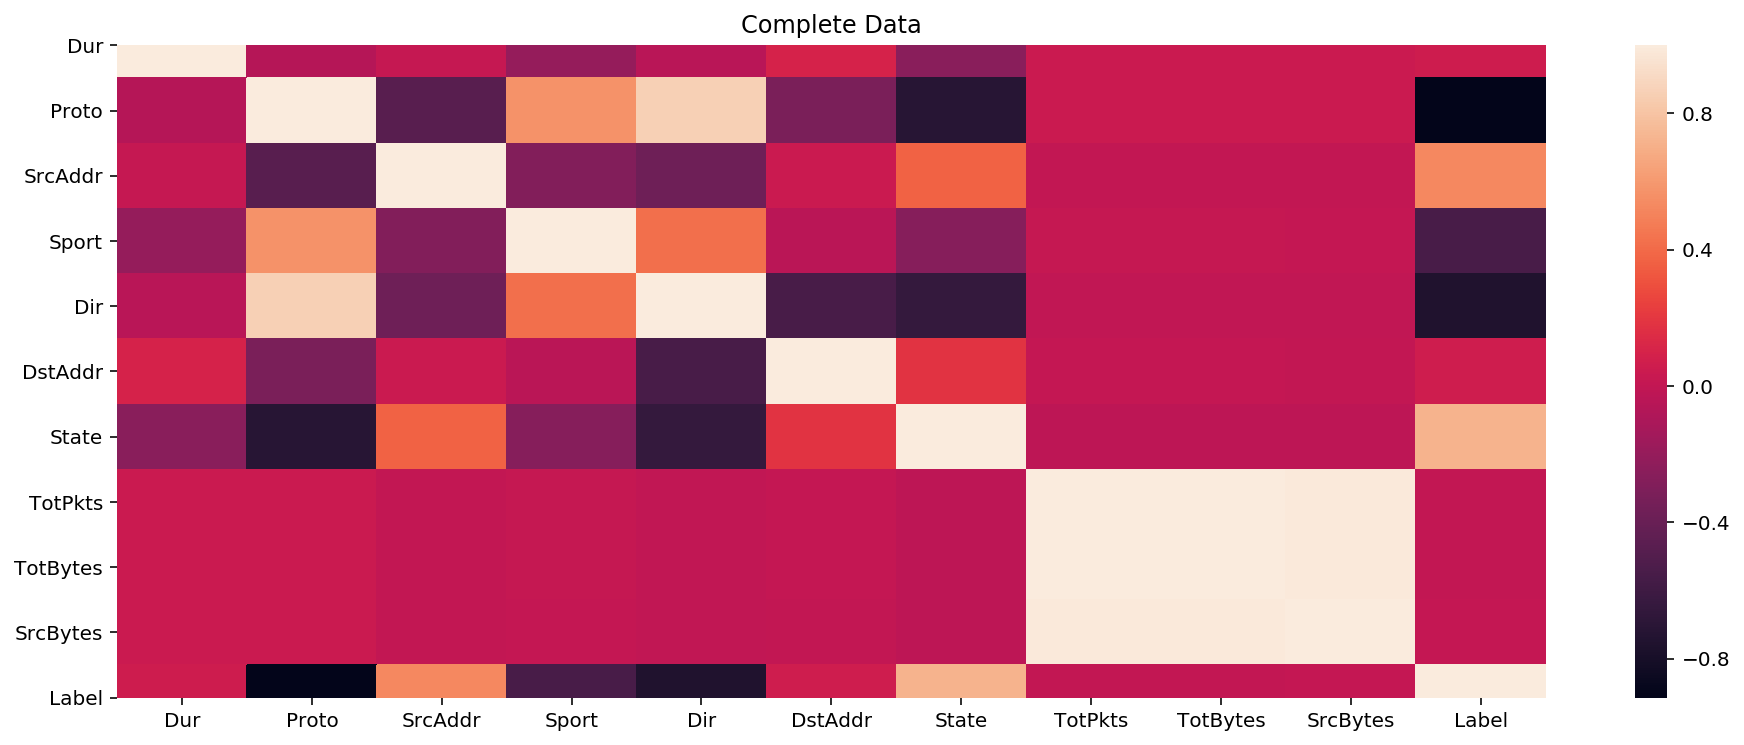

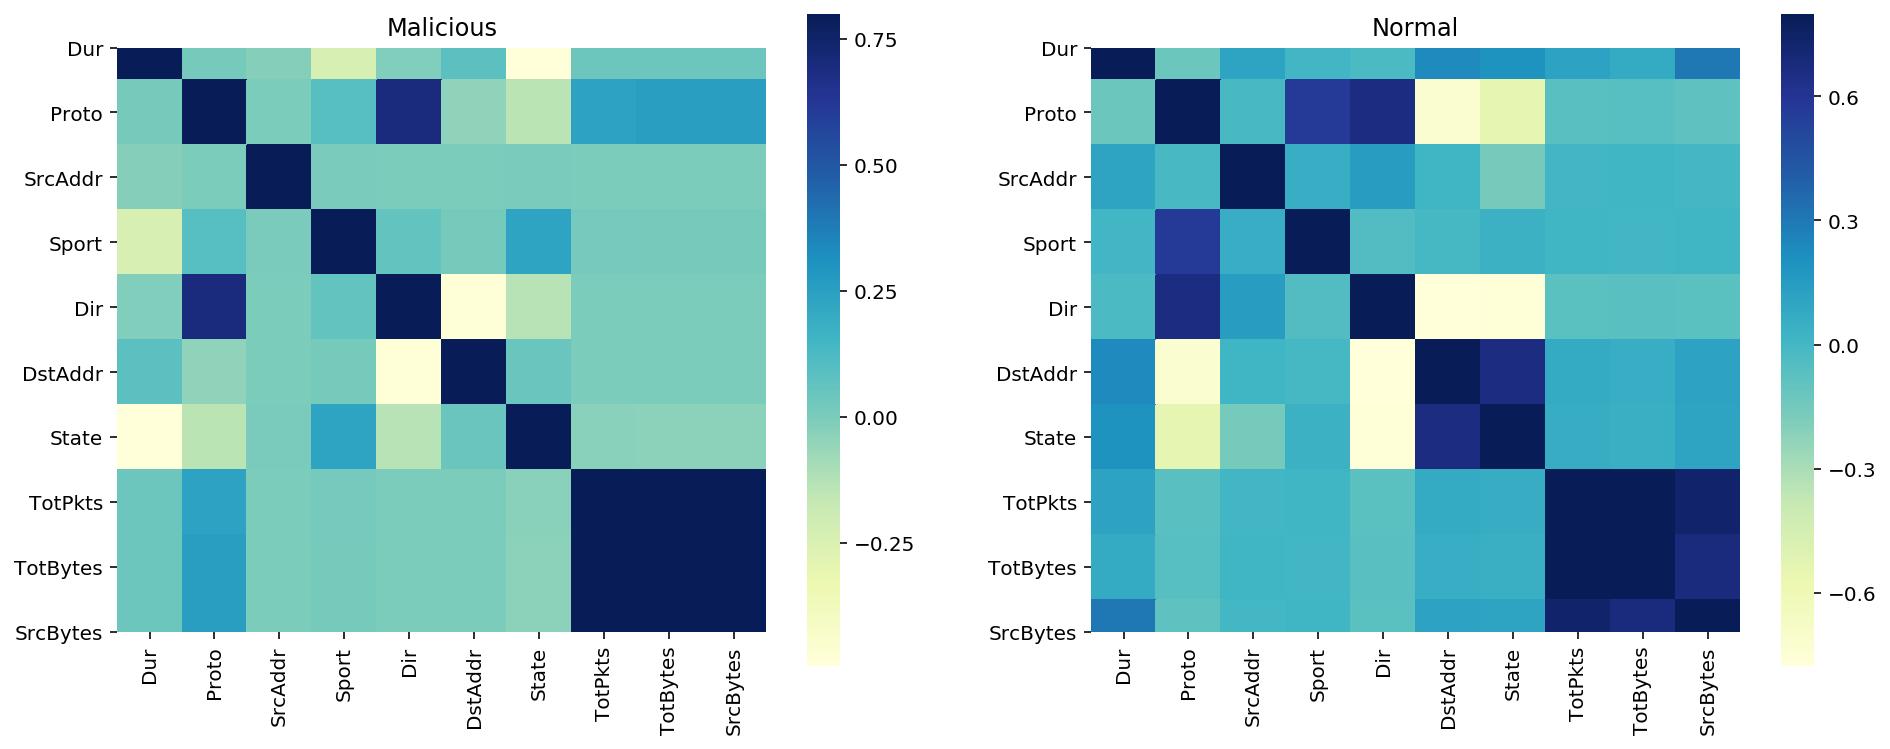

In [7]:
# correlation matrices
f, (ax1) = plt.subplots(1,figsize =(16, 6))
sns.heatmap(data_WB_cleaned.corr())
ax1.set_title('Complete Data')
plt.show()


f, (ax1, ax2) = plt.subplots(1,2,figsize =(16, 6))

sns.heatmap(data_M.drop(['Label'], axis=1).corr(), vmax = .8, square=True, ax = ax1, cmap = 'YlGnBu')
ax1.set_title('Malicious')

sns.heatmap(data_NM.drop(['Label'], axis=1).corr(), vmax = .8, square=True, ax = ax2, cmap = 'YlGnBu');
ax2.set_title('Normal')

plt.show()

In [8]:
#Looking at the correlation of all features with the labels. 
data_WB_cleaned.corr()

,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,State,TotPkts,TotBytes,SrcBytes,Label
Dur,1.000000,-0.059651,0.019821,-0.202402,-0.045376,0.101189,-0.253972,0.040007,0.041698,0.039328,0.050622
Proto,-0.059651,1.000000,-0.480068,0.570802,0.860547,-0.318632,-0.712716,0.041047,0.042357,0.039165,-0.914309
SrcAddr,0.019821,-0.480068,1.000000,-0.284142,-0.369949,0.036393,0.369286,-0.000524,0.000155,0.003175,0.523478
Sport,-0.202402,0.570802,-0.284142,1.000000,0.417685,-0.033035,-0.269878,0.014761,0.013651,0.009765,-0.553765
Dir,-0.045376,0.860547,-0.369949,0.417685,1.000000,-0.549063,-0.650457,-0.004379,-0.005671,-0.005320,-0.754101
DstAddr,0.101189,-0.318632,0.036393,-0.033035,-0.549063,1.000000,0.179736,0.008281,0.007701,0.000994,0.062006
State,-0.253972,-0.712716,0.369286,-0.269878,-0.650457,0.179736,1.000000,-0.020216,-0.021621,-0.018281,0.718407
TotPkts,0.040007,0.041047,-0.000524,0.014761,-0.004379,0.008281,-0.020216,1.000000,0.998092,0.992488,-0.001117
TotBytes,0.041698,0.042357,0.000155,0.013651,-0.005671,0.007701,-0.021621,0.998092,1.000000,0.991953,-0.000018
SrcBytes,0.039328,0.039165,0.003175,0.009765,-0.005320,0.000994,-0.018281,0.992488,0.991953,1.000000,0.006605


## Analysis of the correlation 
Through the correlation plot we determine the most important features in determining whether a data point is malicious or not based on whether they have the high correlation with the label: `Proto`, `Dir`, `State`


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


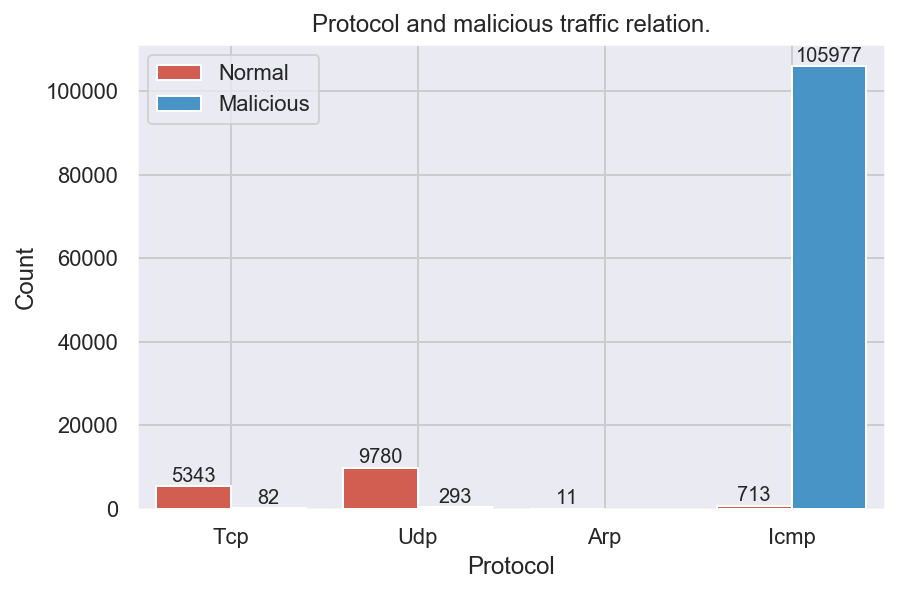

In [9]:
sns.set(rc={'figure.figsize':(6.7,4.27)})
    
flatui = ["#e74c3c","#3498db", "#2ecc71"]
ax = sns.countplot(x="Proto", hue="Label", data=data_vis, palette=flatui)
ax.set_title('Protocol and malicious traffic relation.')
ax.grid(color='#cccccc')
ax.set_ylabel('Count')
ax.set_xlabel('Protocol')
ax.set(xticklabels=["Tcp","Udp","Arp","Icmp"])
ax.legend(["Normal","Malicious"])
max_height = 0

for p in ax.patches:
    if p.get_height() > max_height:
        max_height = p.get_height()
    
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2,
            height + 0.01*max_height,'{:1d}'.format(height.astype(int)),
            ha="center",size=10)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


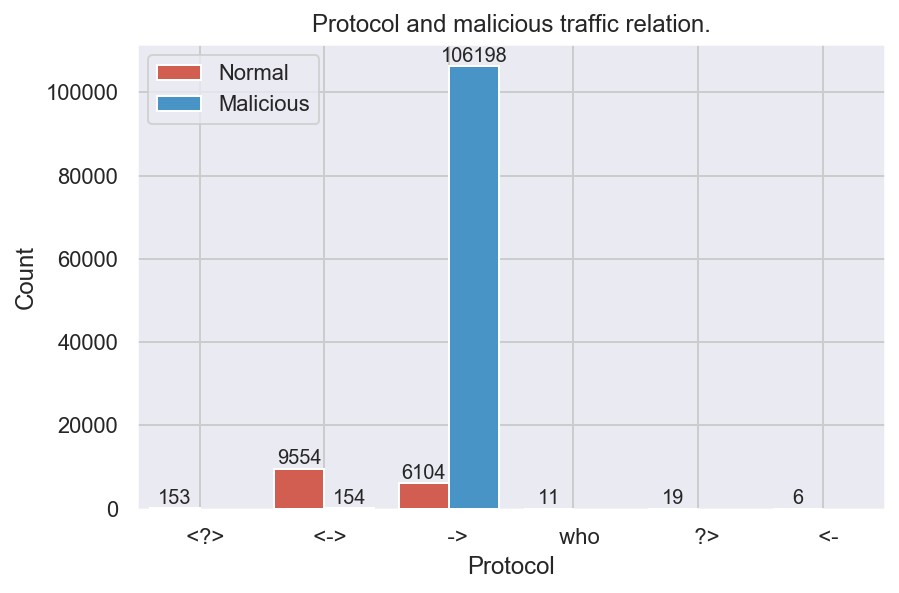

In [10]:
sns.set(rc={'figure.figsize':(6.7,4.27)})
    
flatui = ["#e74c3c","#3498db", "#2ecc71"]
ax = sns.countplot(x="Dir", hue="Label", data=data_vis, palette=flatui)
ax.set_title('Protocol and malicious traffic relation.')
ax.grid(color='#cccccc')
ax.set_ylabel('Count')
ax.set_xlabel('Protocol')
ax.legend(["Normal", "Malicious"])
max_height = 0

for p in ax.patches:
    if p.get_height() > max_height:
        max_height = p.get_height()
    
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2,
            height + 0.01*max_height,'{:1d}'.format(height.astype(int)),
            ha="center",size=10)

### Looking through the visualisations
From the visualisations, we can see that the categorical (hence already discrete) features, `Proto` and `Dir` have a major influence on whether a certain record in the netflow is malicious (or not). Seems like tweaking these features can infect a netflow! Additionally, the `State` feature is also important but the visualisation is not useful due to the multitude of categories. 

Considering the correlation heatmaps of the malicious and normal datasets, we observe the correlations for `Proto` and `State` with the other features. It is clear to see that `Proto` has a higher correlation with the `TotBytes` in the malicious dataset than the normal dataset which means, `TotBytes` has a different behaviour for malicious netflows. Similarly, we see the `State` feature shows different correlations with the `Dur` feature between the malicious and normal datasets. With this premise, we believe discretizing the `TotBytes` and `Dur` are going to useful for studying an infected host. 

In [11]:
#Selecting a certain infected host.
data_infected_host = data_M.loc[data_M["SrcAddr"]==12]

Now we plot the within sum of squares distance for both features for varying number of clusters and use the elbow method to select the appropriate number of bins as was done in paper 4 of the assignment's resource section. 

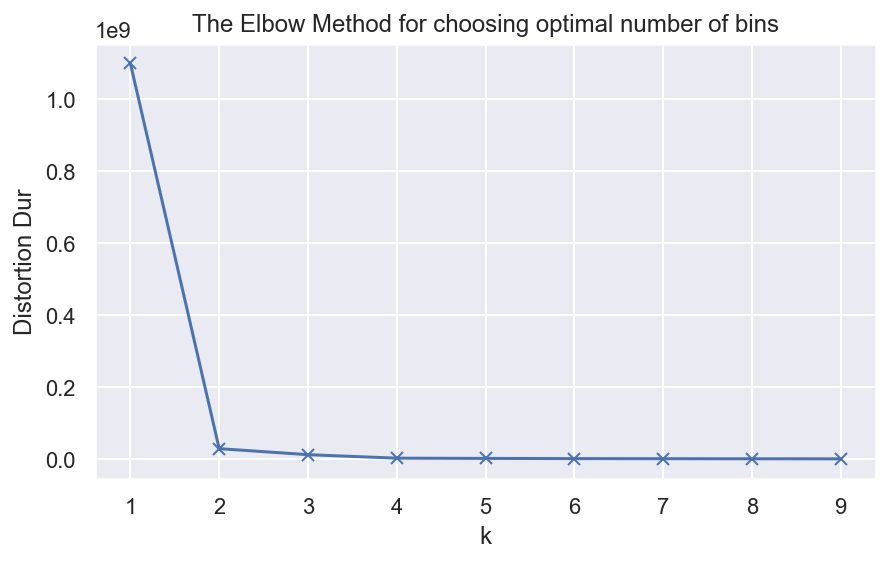

In [12]:
#Calculating Distortions for DUR feature.
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(data_infected_host["Dur"].values.reshape(-1,1))
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(7,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion Dur')
plt.title('The Elbow Method for choosing optimal number of bins')
plt.show()

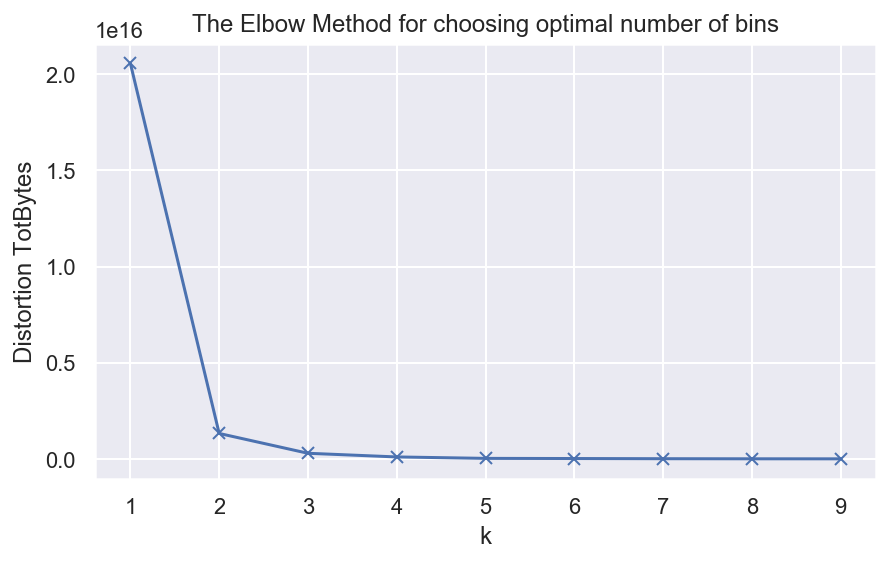

In [13]:
#Distortions for TotBytes
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(data_infected_host["TotBytes"].values.reshape(-1,1))
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(7,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion TotBytes')
plt.title('The Elbow Method for choosing optimal number of bins')
plt.show()

Based on the above plots, we see that selecting 3 bins for both features is reasonable. 

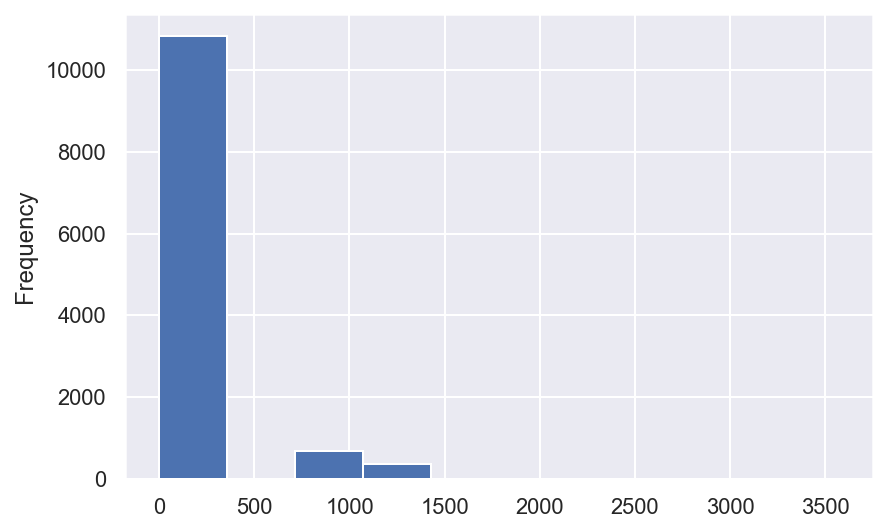

In [14]:
ax=data_infected_host["Dur"].plot(kind="hist")

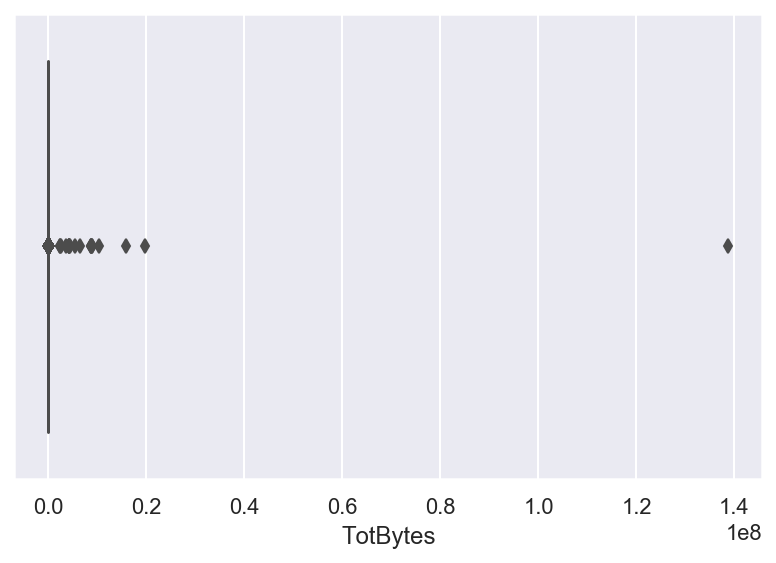

In [15]:
ax=sns.boxplot(data_infected_host["TotBytes"])

As shown by the graphs above, there seems to be a great deal of outliers in both the concerned features, therefore we must look at ways to make these continous by removing outliers which will allow us to discretize them better. 

In [16]:
#This range isn't right. 
data_infected_host["TotBytes"].min(),data_infected_host["TotBytes"].max()

(60, 138720832)

In [17]:
TotBytes=data_infected_host["TotBytes"].values

#last 20 values are very large. 
TotBytes_Pure = TotBytes[:-20]

# Getting the outliers to see what they look like for the reviewer.
TotBytes_Outliers=TotBytes[-20:]

#Therefore we have 2 valid intervals based on quantile based discretization and the 3rd will be for the outliers. 
print(str(pd.qcut(TotBytes_Pure, q=2))[199:])


Categories (2, interval[float64]): [(59.999, 1066.0] < (1066.0, 138720832.0]]


In [18]:
#Lets discretize the feature TotBytes now based on the ranges defined by qcut. 
data_infected_host.loc[(data_infected_host['TotBytes']>59.99) &(data_infected_host['TotBytes']<=1066.0) ,'New_TotBytes'] = 'Level_1'
data_infected_host.loc[(data_infected_host['TotBytes']>1066) &(data_infected_host['TotBytes']<=55432) ,'New_TotBytes'] = 'Level_2'
data_infected_host.loc[(data_infected_host['TotBytes']>55432),'New_TotBytes'] = 'Level_3'
data_infected_host["New_TotBytes"].unique()

array(['Level_1', 'Level_2', 'Level_3'], dtype=object)

In [19]:
# Now doing the same for "Dur" feature. This range doesn't look right. 
data_infected_host["Dur"].min(),data_infected_host["Dur"].max()

(0.0, 3570.946045)

In [20]:
data_infected_host.groupby(["Dur"]).count()

,StartTime,Proto,SrcAddr,Sport,Dir,DstAddr,State,TotPkts,TotBytes,SrcBytes,Label,New_TotBytes
Dur,,,,,,,,,,,,
0.000000,10793,10793,10793,10793,10793,10793,10793,10793,10793,10793,10793,10793
0.000227,1,1,1,1,1,1,1,1,1,1,1,1
0.000233,1,1,1,1,1,1,1,1,1,1,1,1
0.000263,1,1,1,1,1,1,1,1,1,1,1,1
0.000345,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1274.888062,1,1,1,1,1,1,1,1,1,1,1,1
1274.926147,1,1,1,1,1,1,1,1,1,1,1,1
1693.866089,1,1,1,1,1,1,1,1,1,1,1,1


The problem is that we cannot get well defined quantiles for such a discontinous array of values. As using pd.qcut(Dur,2), this doesn't work. But building upon the intuition of clustering based on the values of the data points into 3 groups (which was shown before using the elbow method), we decided to use the sklearn `KBinDiscretizer` to create requisite and relevant bins. 

In [21]:
#Lets discretize the feature Dur now.
Dur=data_infected_host["Dur"].values
Binner = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')
data_infected_host.loc[:,"New_Dur"]=Binner.fit_transform(Dur.reshape(-1,1))
data_infected_host.loc[(data_infected_host['New_Dur']==0.0) ,'New_Dur'] = 'Level_1'
data_infected_host.loc[(data_infected_host['New_Dur']==1.0) ,'New_Dur'] = 'Level_2'
data_infected_host.loc[(data_infected_host['New_Dur']==2.0) ,'New_Dur'] = 'Level_3'
data_infected_host["New_Dur"].unique()

array(['Level_1', 'Level_3', 'Level_2'], dtype=object)

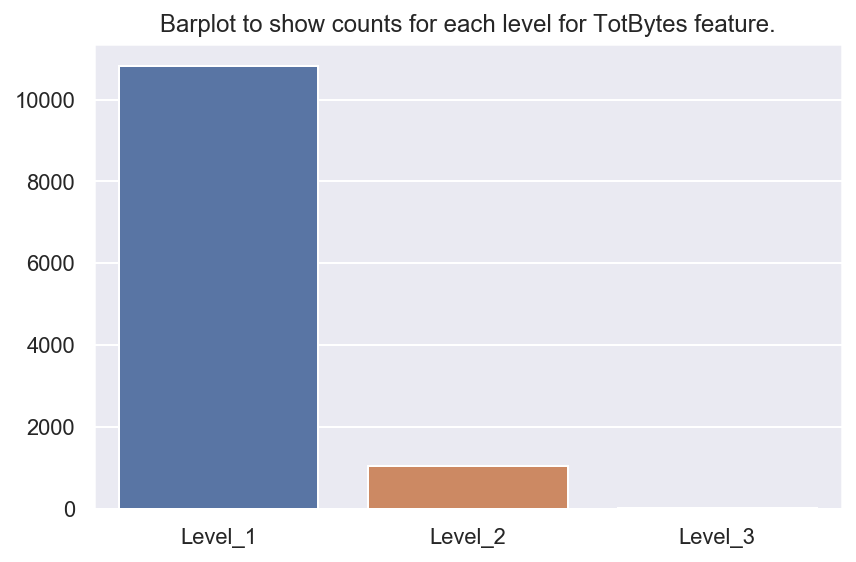

In [22]:
ax=sns.barplot(data_infected_host["New_TotBytes"].value_counts().index,data_infected_host["New_TotBytes"].value_counts().values)
ax.set_title("Barplot to show counts for each level for TotBytes feature.")
plt.show()

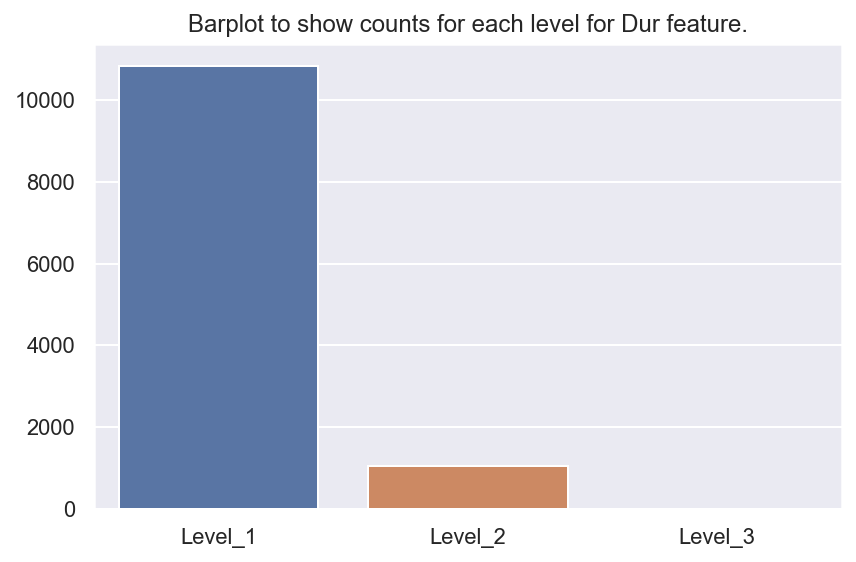

In [23]:
ax=sns.barplot(data_infected_host["New_Dur"].value_counts().index,data_infected_host["New_Dur"].value_counts().values)
ax.set_title("Barplot to show counts for each level for Dur feature.")
plt.show()

Based on this discritization and the barplots of the different levels of the individual features we see that values majorly in the range of level_1 for both "Dur"(0.0-367.65 seconds) and "TotBytes"(66-1066 bytes).

To combine features, we take the cartesian product of the three levels for each of the two features, giving us 9 possibilites as follows:


| Dur           | TotBytes      | Combined_Feature |
| ------------- |:-------------:| :---------------:|
| Level_1       |  Level_1      | Combined_Level_1 |
| Level_1       |  Level_2      | Combined_Level_2 |
| Level_1       |  Level_3      | Combined_Level_3 |
| Level_2       |  Level_1      | Combined_Level_4 | 
| Level_2       |  Level_2      | Combined_Level_5 |   
| Level_2       |  Level_3      | Combined_Level_6 | 
| Level_3       |  Level_1      | Combined_Level_7 |
| Level_3       |  Level_2      | Combined_Level_8 |
| Level_3       |  Level_3      | Combined_Level_9 | 



In [24]:
#Combining features based on the 2 individual discretized features for Dur and TotBytes. 
combined_levels=[]
for i,j in zip(data_infected_host["New_Dur"].values,data_infected_host["New_TotBytes"].values):
    if (i=="Level_1") & (j=="Level_1"):
        combined_levels.append("Combined_Level_1")
    elif (i=="Level_1") & (j=="Level_2"):
        combined_levels.append("Combined_Level_2")
    elif (i=="Level_1") & (j=="Level_3"):
        combined_levels.append("Combined_Level_3")
    elif (i=="Level_2") & (j=="Level_1"):
        combined_levels.append("Combined_Level_4")
    elif (i=="Level_2") & (j=="Level_2"):
        combined_levels.append("Combined_Level_5")
    elif (i=="Level_2") & (j=="Level_3"):
        combined_levels.append("Combined_Level_6")
    elif (i=="Level_3") & (j=="Level_1"):
        combined_levels.append("Combined_Level_7")
    elif (i=="Level_3") & (j=="Level_2"):
        combined_levels.append("Combined_Level_8")
    elif (i=="Level_3") & (j=="Level_3"):
        combined_levels.append("Combined_Level_9")

data_infected_host.loc[:,"Combined_Levels"]=combined_levels        

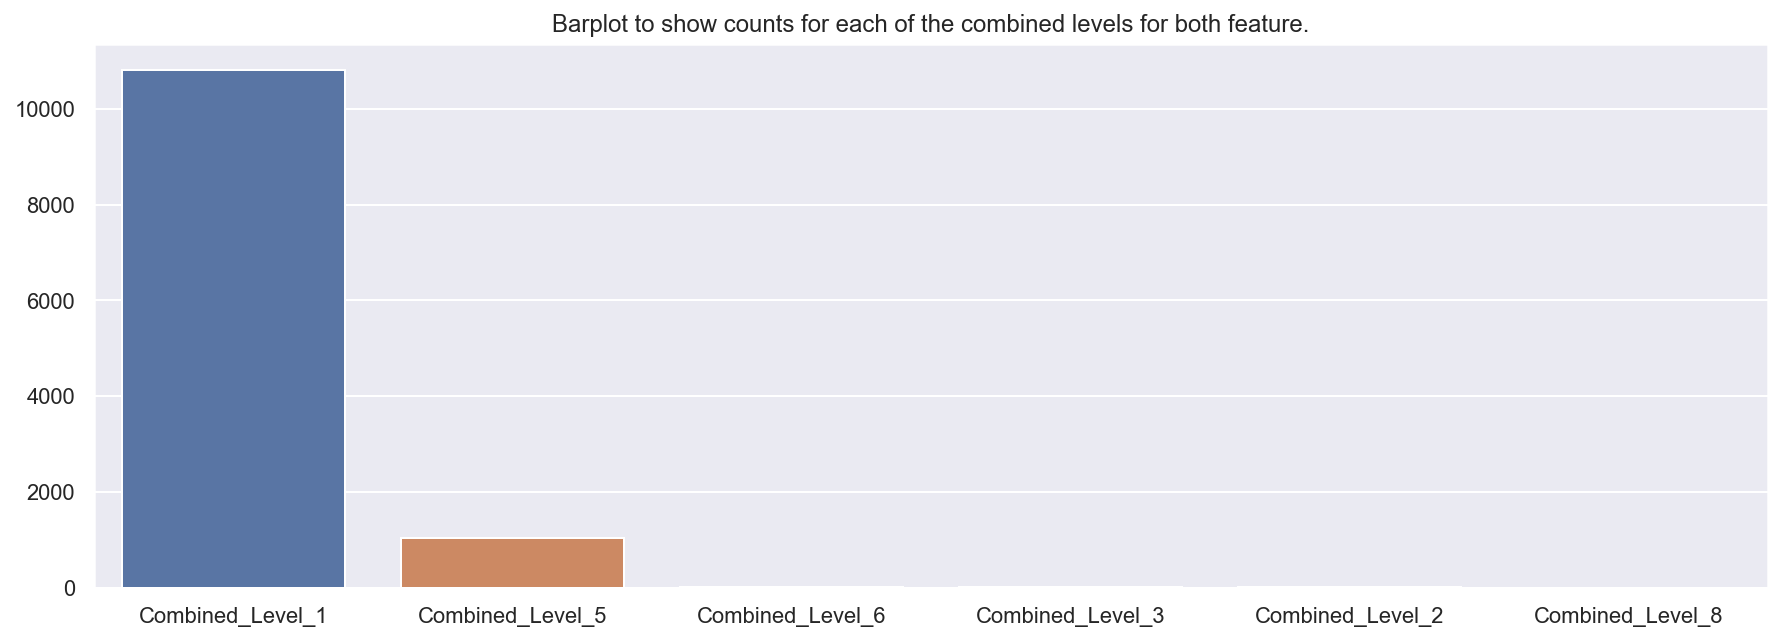

In [25]:
fig,ax= plt.subplots(figsize=(15,5))
ax=sns.barplot(data_infected_host["Combined_Levels"].value_counts().index,data_infected_host["Combined_Levels"].value_counts().values)
ax.set_title("Barplot to show counts for each of the combined levels for both feature.")
plt.show()

Overall, we see that combined_level_1 for this host is quite indicative of malicious activity. This is essentially when Dur and TotBytes level_1s are combined, this is expected ofcourse as they were the most indicative levels for the individual features as well. We then see that combined_level 5 which is a combination of Level_2 from the both features has the second highest frequency. This is of course for a particular infected host.

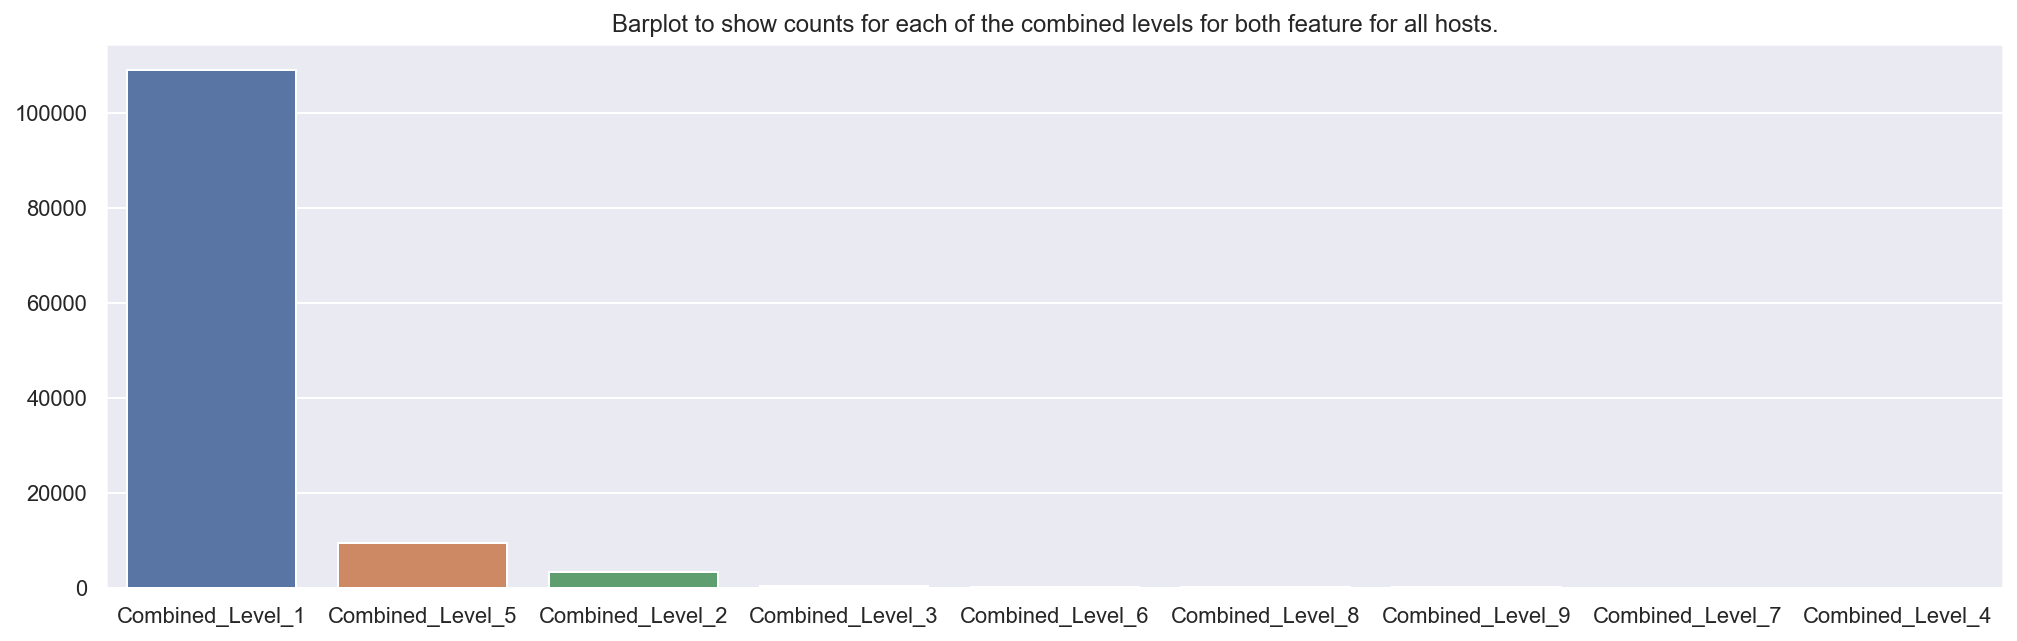

In [26]:
#As a final aspect of the first task, we are asked to discretize our chosen features for every host. 
#Therefore I will do the discretization for the entire dataset without background.
data_discrete= data_WB_cleaned.copy()
#Lets discretize the feature TotBytes
data_discrete.loc[(data_discrete['TotBytes']>59.99) &(data_discrete['TotBytes']<=1066.0) ,'New_TotBytes'] = 'Level_1'
data_discrete.loc[(data_discrete['TotBytes']>1066) &(data_discrete['TotBytes']<=55432) ,'New_TotBytes'] = 'Level_2'
data_discrete.loc[(data_discrete['TotBytes']>55432),'New_TotBytes'] = 'Level_3'
#Lets discretize the feature Dur.
Binner = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')
data_discrete.loc[:,"New_Dur"]=Binner.fit_transform(data_discrete["Dur"].values.reshape(-1,1))
data_discrete.loc[(data_discrete['New_Dur']==0.0) ,'New_Dur'] = 'Level_1'
data_discrete.loc[(data_discrete['New_Dur']==1.0) ,'New_Dur'] = 'Level_2'
data_discrete.loc[(data_discrete['New_Dur']==2.0) ,'New_Dur'] = 'Level_3'
#Creating the combined_feature based on the above two discretizations.
combined_levels_d=[]
for i,j in zip(data_discrete["New_Dur"].values,data_discrete["New_TotBytes"].values):
    if (i=="Level_1") & (j=="Level_1"):
        combined_levels_d.append("Combined_Level_1")
    elif (i=="Level_1") & (j=="Level_2"):
        combined_levels_d.append("Combined_Level_2")
    elif (i=="Level_1") & (j=="Level_3"):
        combined_levels_d.append("Combined_Level_3")
    elif (i=="Level_2") & (j=="Level_1"):
        combined_levels_d.append("Combined_Level_4")
    elif (i=="Level_2") & (j=="Level_2"):
        combined_levels_d.append("Combined_Level_5")
    elif (i=="Level_2") & (j=="Level_3"):
        combined_levels_d.append("Combined_Level_6")
    elif (i=="Level_3") & (j=="Level_1"):
        combined_levels_d.append("Combined_Level_7")
    elif (i=="Level_3") & (j=="Level_2"):
        combined_levels_d.append("Combined_Level_8")
    elif (i=="Level_3") & (j=="Level_3"):
        combined_levels_d.append("Combined_Level_9")

data_discrete["Combined_levels"] = combined_levels_d        
#Plotting the frequencies of the combined_feature levels. 
fig,ax= plt.subplots(figsize=(17,5))
ax=sns.barplot(data_discrete["Combined_levels"].value_counts().index,data_discrete["Combined_levels"].value_counts().values)
ax.set_title("Barplot to show counts for each of the combined levels for both feature for all hosts.")
plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


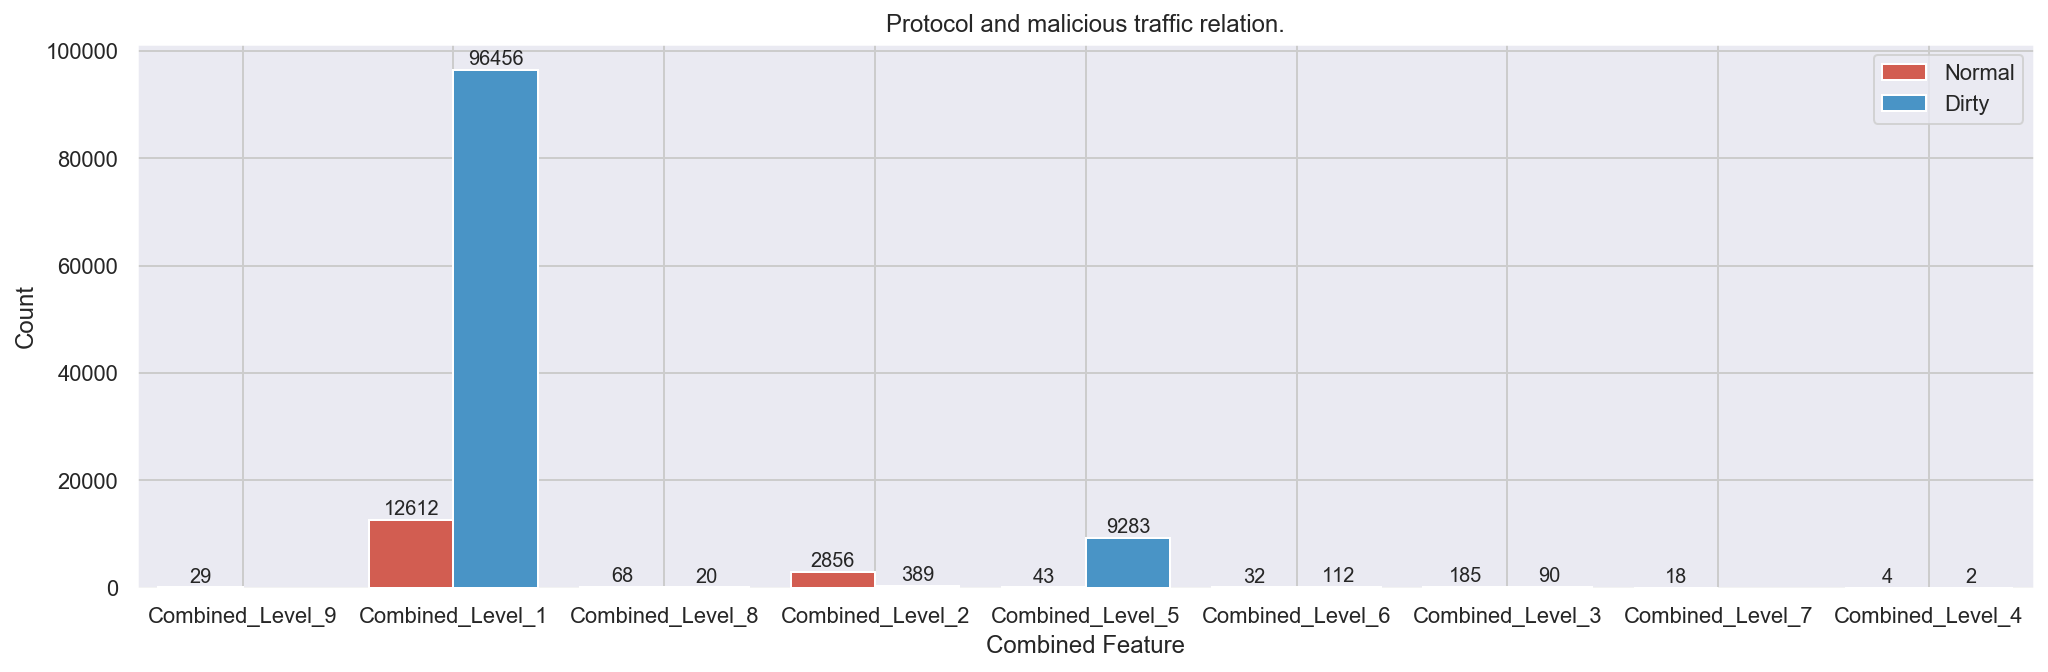

In [27]:
#Plotting relative frequencies of the combined_level features for malicious and normal netflows. 
sns.set(rc={'figure.figsize':(17,5)})
    
flatui = ["#e74c3c","#3498db", "#2ecc71"]
ax = sns.countplot(x="Combined_levels", hue="Label", data=data_discrete, palette=flatui)
ax.set_title('Protocol and malicious traffic relation.')
ax.grid(color='#cccccc')
ax.set_ylabel('Count')
ax.set_xlabel('Combined Feature')
ax.legend(["Normal", "Dirty"])
max_height = 0

for p in ax.patches:
    if p.get_height() > max_height:
        max_height = p.get_height()
    
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2,
            height + 0.01*max_height,'{:1d}'.format(height.astype(int)),
            ha="center",size=10)

Therefore for scenario 10 and based on my discretization we see that the combined_feature levels 1 and 5 are majorly indicative of malicious netflow data. 

## 2. Frequent task – Aditya Kunar

### 2a. Use the SPACE SAVING algorithm

In [28]:
#Without space saving to compare results with space saving.

#These are the values of my combined_feature.
Combined_feature=data_discrete.Combined_levels.values

#Creating the different n-grams.
n = 3
threegrams = ngrams(Combined_feature, n)

#Creating a dictionary that stores the counts for the different ngrams. 
dicky={}
for i in threegrams:
    s = "-"
    s = s.join(i)
    dicky[s] = dicky.get(s, 0) + 1

#Sorting the dictionary.
dicky_sorted={k: v for k, v in sorted(dicky.items(), key=lambda item: -1*item[1])} 
#Returning top 10 as demanded in the task.
top10 = {k: dicky_sorted[k] for k in list(dicky_sorted)[:10]}
top10

{'Combined_Level_1-Combined_Level_1-Combined_Level_1': 88942,
 'Combined_Level_1-Combined_Level_5-Combined_Level_1': 7687,
 'Combined_Level_1-Combined_Level_1-Combined_Level_5': 7656,
 'Combined_Level_5-Combined_Level_1-Combined_Level_1': 7643,
 'Combined_Level_1-Combined_Level_1-Combined_Level_2': 1633,
 'Combined_Level_2-Combined_Level_1-Combined_Level_1': 1632,
 'Combined_Level_1-Combined_Level_2-Combined_Level_1': 1390,
 'Combined_Level_2-Combined_Level_2-Combined_Level_2': 1023,
 'Combined_Level_5-Combined_Level_1-Combined_Level_5': 772,
 'Combined_Level_1-Combined_Level_5-Combined_Level_5': 742}

In [29]:
#With space saving. 

"""
SpaceSpaver-> Here I implement the space saving algorithm as described in the lecture slides. 
              Inputs-:
              feature=> the feature I discretized in task1,
              gram_length=> 3 in our case as we want 3-grams.
              k=> The number of counters we want to use. 
"""
def SpaceSpaver(feature,gram_length,k):
    #Creating the threegrams.
    threegrams = ngrams(feature, gram_length)
    #Creating a dictionary where the size is controlled by k.
    dicky_SV={}
    #Iterating through the threegrams.
    for i in threegrams:
        #s is the item for which we need the counts.
        s = "-"
        s = s.join(i)
        #Here we keep adding elements into the dictionary if the total number of items is less than k.
        if len(list(dicky_SV.keys()))<=k:
            #Adds one if it exists or initialises with 1 if doesn't exist.
            dicky_SV[s] = dicky_SV.get(s, 0) + 1
        #If greater than k.
        elif len(list(dicky_SV.keys()))>k:
            #If s is in the dictionary already, we just increase the count.
            if s in list(dicky_SV.keys()):
                dicky_SV[s]+=1
            #If its not, we need to replace the current item with lowest count with s and add 1.
            else:
                keytoR=(min(dicky_SV, key=dicky_SV.get))
                dicky_SV[s] = dicky_SV.pop(keytoR)
                dicky_SV[s]+=1
    #Sorting the dictionary.
    dicky_SV_sorted={k: v for k, v in sorted(dicky_SV.items(), key=lambda item: -1*item[1])} 
    #Returning top 10 as demanded in the task.
    top10_SV = {k: dicky_SV_sorted[k] for k in list(dicky_SV_sorted)[:10]}
    return top10_SV

In [30]:
#Using the space-saver with 12 counters. 
top10_SV=SpaceSpaver(Combined_feature,3,12)
top10_SV

{'Combined_Level_1-Combined_Level_1-Combined_Level_1': 88942,
 'Combined_Level_1-Combined_Level_5-Combined_Level_1': 7764,
 'Combined_Level_1-Combined_Level_1-Combined_Level_5': 7730,
 'Combined_Level_5-Combined_Level_1-Combined_Level_1': 7714,
 'Combined_Level_1-Combined_Level_1-Combined_Level_2': 1634,
 'Combined_Level_2-Combined_Level_1-Combined_Level_1': 1634,
 'Combined_Level_1-Combined_Level_2-Combined_Level_1': 1392,
 'Combined_Level_2-Combined_Level_2-Combined_Level_2': 1026,
 'Combined_Level_5-Combined_Level_1-Combined_Level_5': 929,
 'Combined_Level_1-Combined_Level_5-Combined_Level_5': 902}

In [31]:
#These are the elements not present in the top 10 Space Spaving item list but are present in the actual top 10.  
set(top10.keys())-set(top10_SV.keys())

set()

We see that all 10 elements are correctly identified if we just use 12 counters. Moreover, the ordering is also preserved correctly.  

### 2b. Analysis and answers to the questions

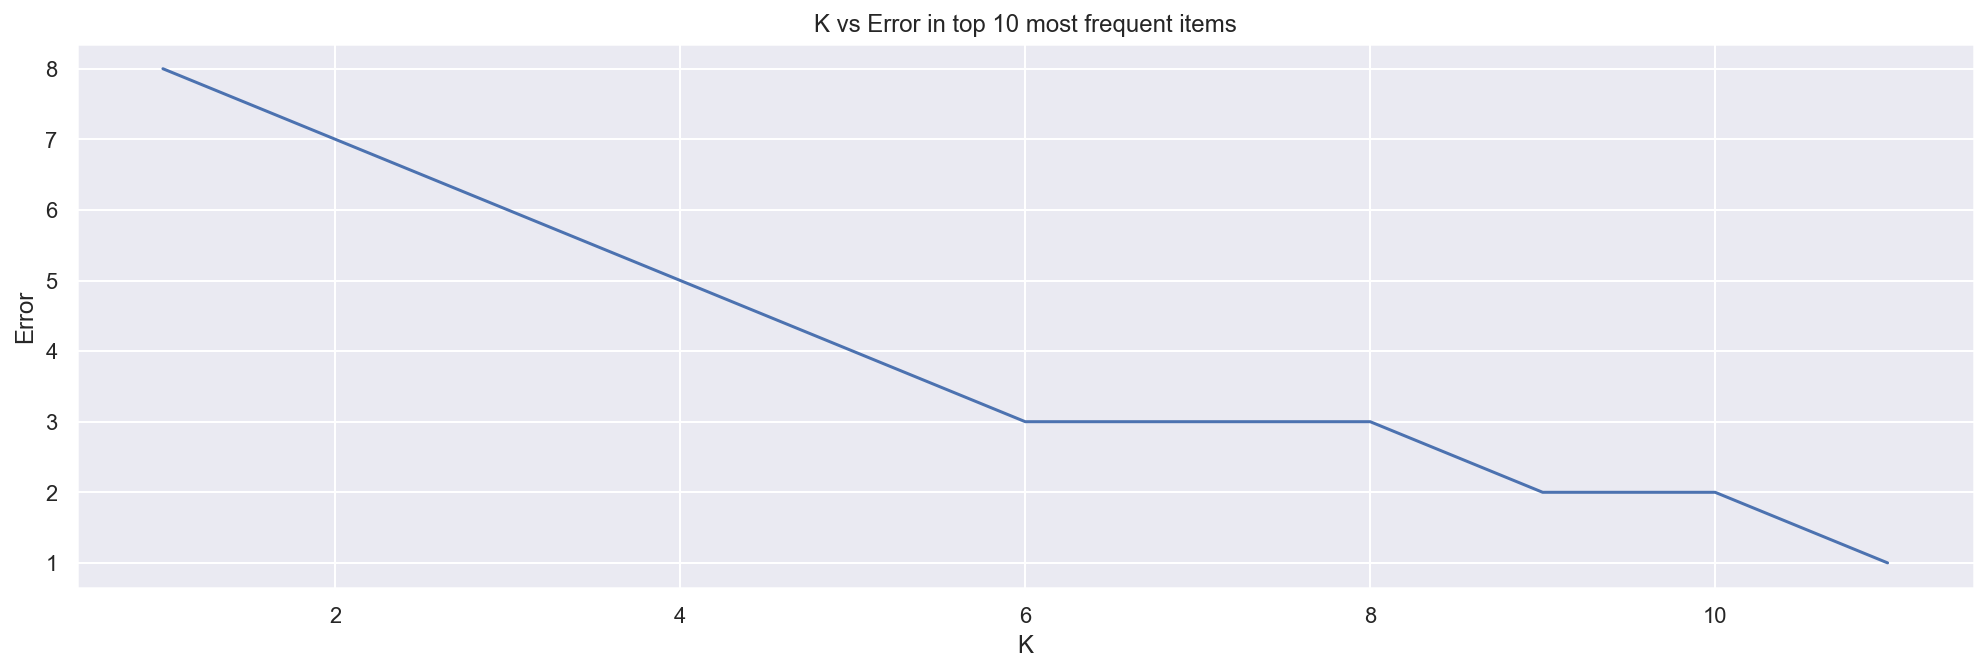

In [32]:
error=[]
for k in range(1,12):
    top10_SV=SpaceSpaver(Combined_feature,3,k)
    error.append(len(list(set(top10.keys())-set(top10_SV.keys()))))
ax=sns.lineplot(x=range(1,12),y=error)
ax.set_title("K vs Error in top 10 most frequent items")
ax.set_xlabel("K")
ax.set_ylabel("Error")
plt.show()    

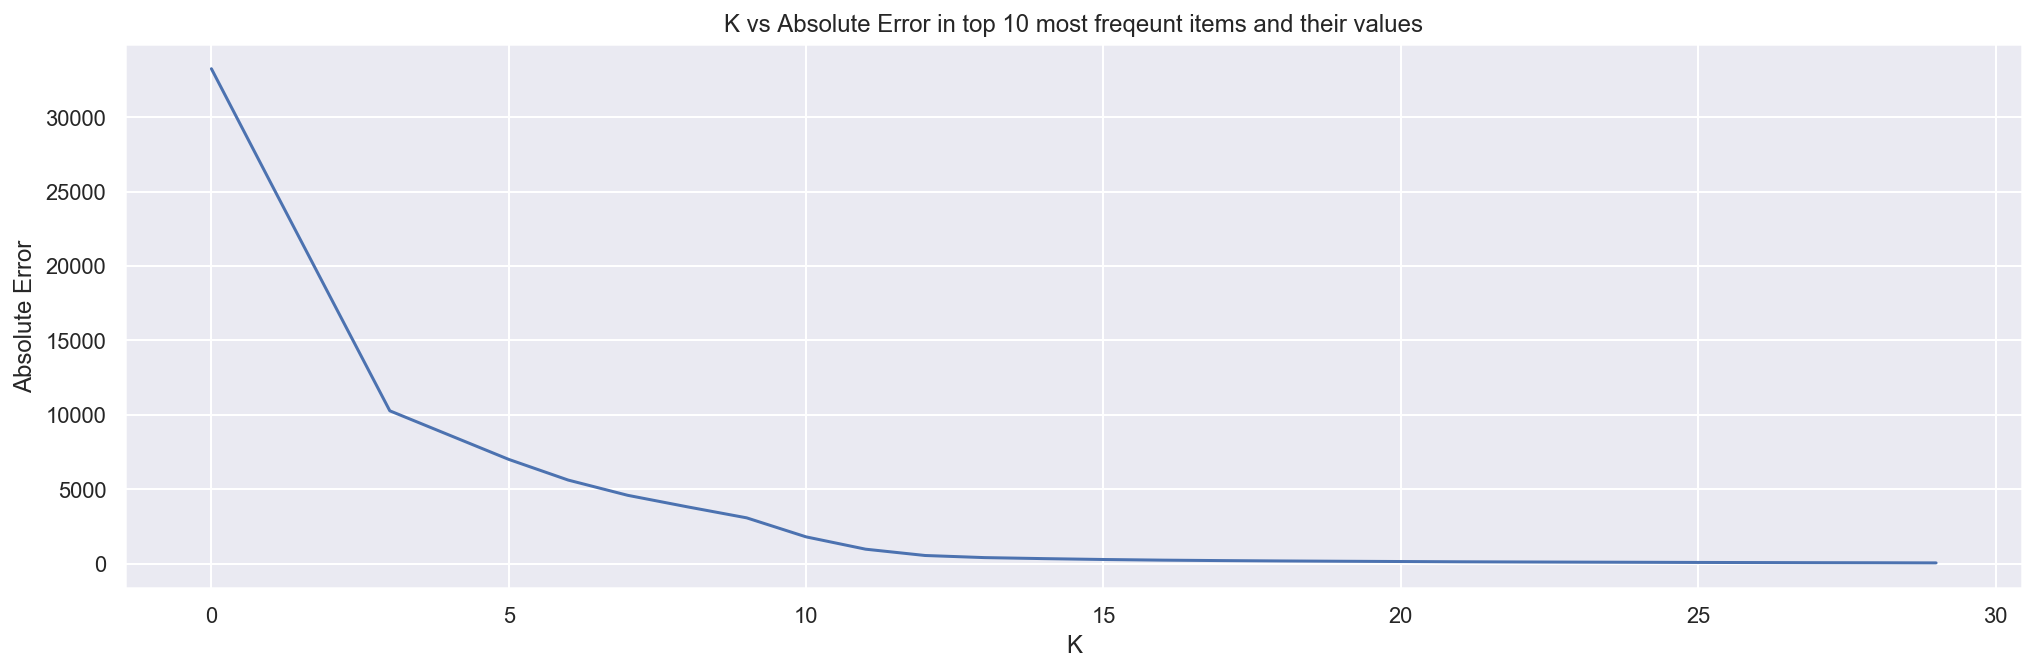

In [33]:
abserror=[]
for k in range(30):
    top10_SV=SpaceSpaver(Combined_feature,3,k)
    aberr=[]
    for i,j in zip(top10_SV.values(),top10.values()):
            aberr.append(abs(j-i))
    
    abserror.append(sum(aberr))
ax=sns.lineplot(x=range(30),y=abserror)
ax.set_title("K vs Absolute Error in top 10 most freqeunt items and their values")
ax.set_xlabel("K")
ax.set_ylabel("Absolute Error")
plt.show()    

Using more counters increases the overall accuracy of the counts of the elements as well as shown in the graph.

We see that the dataset is clearly skewed based on the barplots shown before. The basic intuition of the space saving algorithm is to make use of the skewed property of the data, since we expect a minority of the elements that are the more frequent ones to get the majority of the hits. Frequent elements will reside in the counters of bigger values, and will not be distorted by the ineffective hits of the infrequent elements, and thus, will never be replaced out of
the monitored counters. Meanwhile, the numerous infrequent elements will be
striving to reside on the smaller counters, whose values will grow slower than
those of the larger counters. The elements that
are growing more popular will gradually be pushed to the top of the list as they
receive more hits. If one of the previously popular elements lost its popularity,
it will receive less hits. Thus, its relative position will decline, as other counters
get incremented, and it might eventually get dropped from the list.
Even if the data is not skewed, the errors in the counters will be inversely
proportional to the number of counters, this is also shown by my graphs as well. Keeping only a moderate
number of counters will guarantee very small errors. This is because the more
counters we keep, the less it is probable to replace elements, and thus, the smaller
the over-estimation errors in counters’ values. 

Note- I must give credit to the authors of the actual space saving paper as the source for this explanation. 

## 3. Sketching task – Anwesh Marwade

### 3a. COUNT-MIN sketch
Steps involved in analysing the count-min sketch are:
1. Counting n-gram frequencies in the general manner (NLTK ngrams)
2. Define the class for a sketch data-structure
3. Use this sketch to count the frequncy from the discretized netflow 
4. Plot the errors vs num_hashes to optimize on the number of hash functions needed

In [34]:
# Scenario 10
# data_discrete = data_discretizer(data1)
discretized = data_discrete.Combined_levels.values

# Creating the different n-grams.
n = 3
threegrams = ngrams(discretized, n)

# Creating a dictionary that stores the counts for the different ngrams. 
gram_freq={}
stream_grams = []
for i in threegrams:
    s = []
    for gram in i:
        s.append(re.findall("\d+",gram)[0])
    
    g = ''.join(s)
    stream_grams.append(g)
    gram_freq[g] = gram_freq.get(g, 0) + 1

# Sorting the ngram_freq dictionary for return top 10 occuring n-grams.
gram_freq={k: v for k, v in sorted(gram_freq.items(), key=lambda item: -1*item[1])} 

# Returning top 10 as demanded in the task.
top10 = {k: gram_freq[k] for k in list(gram_freq)[:10]}
top10_ngrams = list(top10.values())
print('Top-10 True Ngram Frequencies')
top10

Top-10 True Ngram Frequencies


{'111': 88942,
 '151': 7687,
 '115': 7656,
 '511': 7643,
 '112': 1633,
 '211': 1632,
 '121': 1390,
 '222': 1023,
 '515': 772,
 '155': 742}

### Define the `sketch` class

Trade off for stream-based counting: __approximation__ vs __sublinear time/space__ operations 

In [35]:
# Count min sketch
class Countminsketch:
    def __init__(self, w, num_hash):
        ''' 
        Method to init the data structure
        width (int): Width of the sketch table or number of posible hash values
        num_hash (int): Depth of the sketch table (also =number of hash functions)
        '''
        self.width = w
        self.num_hash = num_hash
        self.table = np.zeros([num_hash, w])  # Creating an empty table
        self.seed = np.random.randint(w, size = num_hash) 

    def increment(self, key):
        ''' 
        Method to increment count of the string under consideration.
        '''
        for i in range(0, self.num_hash):
            index = mmh3.hash(key, self.seed[i]) % self.width
            
            self.table[i, index] = self.table[i, index]+1
            
    def estimate_freq(self, key):
        ''' 
        Method to estimate the frequency of the key (string that is passed as argument)
        '''
        min_arr = []
        for i in range(0, self.num_hash):
            index = mmh3.hash(key, self.seed[i]) % self.width
            min_arr.append(self.table[i, index])
            
        return min(min_arr)
    
    def show_table(self):
        return self.table
    
def CMS_wrapper_top_10(w, d, data, p=False):
    cms = Countminsketch(w, d)
    for i in stream_grams:
        cms.increment(i)
    countmin_dict = {}
    for gram in set(stream_grams):
        countmin_dict[gram] = int(cms.estimate_freq(gram))
    top10 = {k: v for k, v in sorted(countmin_dict.items(), key=lambda item: -1*item[1])}
    if p:
        return top10
    return list(top10.values())[:10]

In [36]:
sketch10 = CMS_wrapper_top_10(10, 20, stream_grams, p=True)
dict(itertools.islice(sketch10.items(), 10))

{'111': 88958,
 '151': 7843,
 '511': 7806,
 '115': 7704,
 '112': 2462,
 '221': 2078,
 '211': 1821,
 '121': 1617,
 '222': 1048,
 '133': 969}

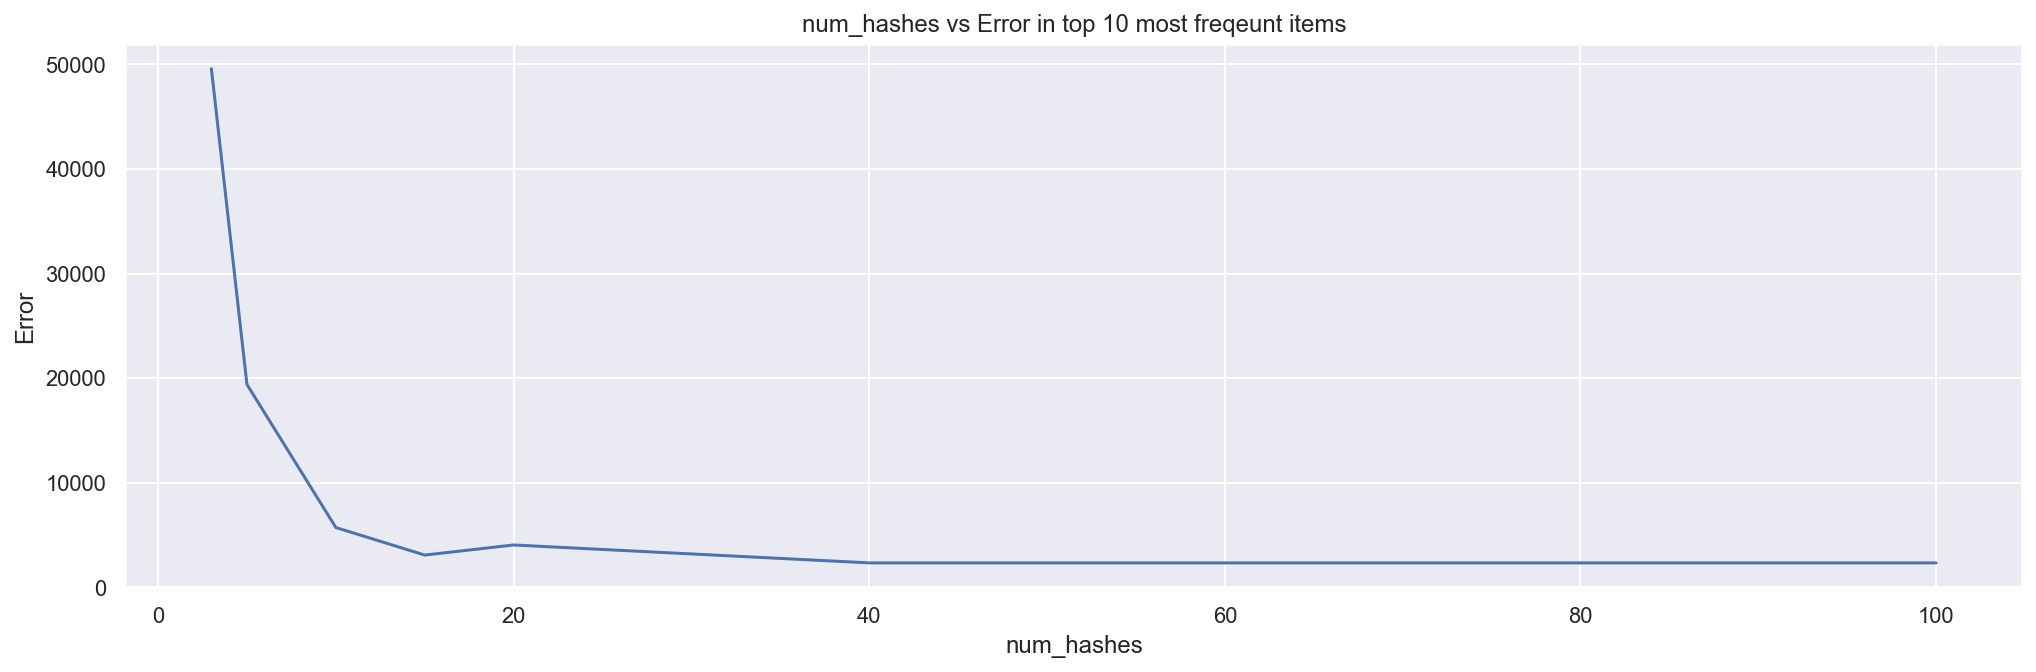

In [37]:

hashes = [3, 5, 10, 15, 20, 40, 100]
error = np.zeros(len(hashes))
for idx, j in enumerate(hashes):
    top10_cms = CMS_wrapper_top_10(10, j, stream_grams)
    error[idx] = (sum([a_i - b_i for a_i, b_i in zip(top10_cms, top10_ngrams)]))
    
ax=sns.lineplot(x=hashes,y=error)
ax.set_title("num_hashes vs Error in top 10 most freqeunt items")
ax.set_xlabel("num_hashes")
ax.set_ylabel("Error")
plt.show()

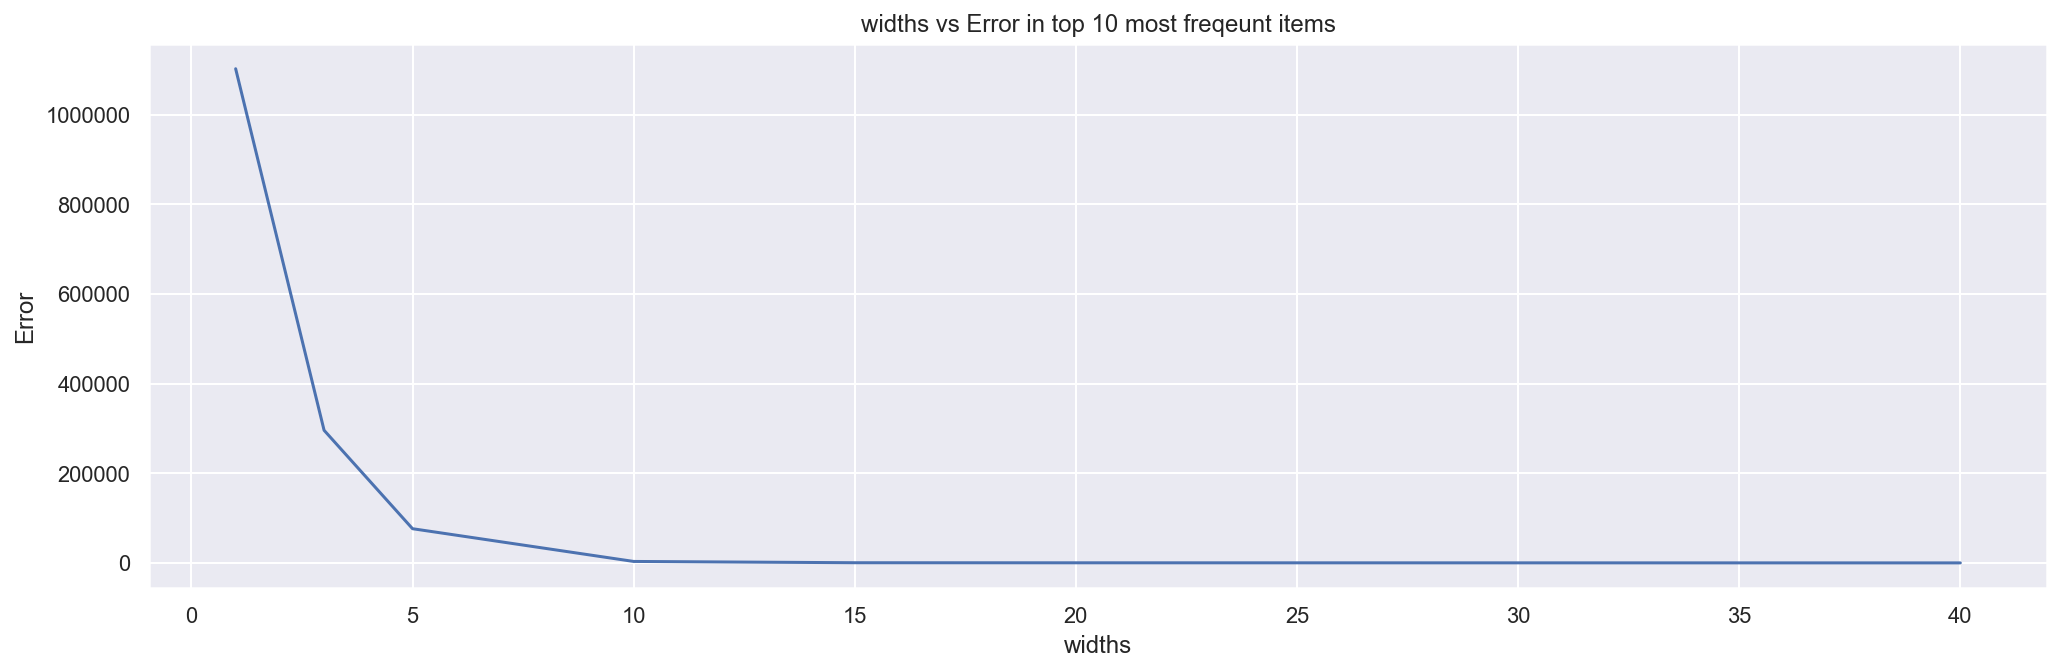

In [38]:
widths = [1, 3, 5, 10, 15, 20, 40]
error = np.zeros(len(widths))
for idx, j in enumerate(widths):
    top10_cms = CMS_wrapper_top_10(j, 20, stream_grams)
    error[idx] = (sum([a_i - b_i for a_i, b_i in zip(top10_cms, top10_ngrams)]))
    
ax=sns.lineplot(x=widths,y=error)
ax.set_title("widths vs Error in top 10 most freqeunt items")
ax.set_xlabel("widths")
ax.set_ylabel("Error")
plt.show()

### 3b. Analysis and answers to the questions

__Width, Num_Hashes:__ By analysing the errors (plots above) we try to optimize the width and the number of hash functions for the Count-Min task. We see (from the num_hashes vs error plot) that the error decreases by increasing the number of hash functions (no observable change after `depth = 20`) which is only logical given that more hash functions (remember, pairwise independent) would result in lesser approximations, implying lower overall error! Additionally, we also observe that the optimal width for this task seems to be around `width = 10`.

__What about the approximation errors?__ It is imperative to understand the trade-off that is inherent with this sketch based min-counting approach. Owing to its incredible efficiency (sublinear access times), _Count-Min Sketch_ allows us to capture the frequencies from a stream of data while not requiring allocation of any extra space on adding a new sequence to the set. The drawback however arises from the _hashing_ that forms the core concept of this sketch based structure. Using hash functions, as we add new events, the chances of collisions (different inputs generating the same hash value) increase as well. More the collisions, higher is the gap between the approximated vs true counts of the stream sequence. It is clear from the graph that by allowing for more hash-functions (increasing depth) the error is expected to reduce. We can confirm on the behaviour of the Count-Min sketch by observing and comparing the counts output by the general (stationary) ngram method (see counts above).

## LSH-Task: Common functions

In [40]:
#Obtaining unique Src-Dst IP pairs.
src=data_discrete["SrcAddr"].values
dst=data_discrete["DstAddr"].values
ip_pairs=[]
for i,j in zip(src,dst):
    ip_pairs.append((i,j))
unique_pairs=list(set(ip_pairs)) 

#Getting the combined_features for each IP-pair and creating n-grams. 
datasubsets=[]
for i in set(unique_pairs):
    datasubsets.append(data_discrete.loc[(data_discrete["SrcAddr"]==i[0])&(data_discrete["DstAddr"]==i[1])])

Combined_pairF=[]
for i in datasubsets:
    Combined_pairF.append(i["Combined_levels"].values)    

Ngram_combined_pairF=[]

for i in Combined_pairF:
    threegrams = ngrams(i, 3)
    Ngram_combined_pairF.append(threegrams)     
    
# pairwise_ngrams stores n-gram frequncy for each ip-pair.     
pairwise_ngrams=[]
for i in Ngram_combined_pairF:
    pairwise_ngram={}
    for j in i:
        s = "-"
        s = s.join(j)
        pairwise_ngram[s] = pairwise_ngram.get(s, 0) + 1
    
    pairwise_ngrams.append(pairwise_ngram) 

#Removing the empty ip_pairs.
index=[]
for i in enumerate(pairwise_ngrams):
    if len(list(i[1].keys()))!=0:
        index.append(i[0]) 
pairwise_ngrams_pure = [i[1] for i in enumerate(list(pairwise_ngrams)) if i[0] in index]        
pairwise_ngrams=pairwise_ngrams_pure

#all keys is essentially the different possible n-grams from all ip-pairs. 
allkeys=[]
for i in pairwise_ngrams:
    for j in list(i.keys()):
        allkeys.append(j)
len(set(allkeys)) 

134

## 4. Min-wise locality sensitive hashing task – Aditya Kunar

For this task-

1) I first obtain the ip pairs. 

2) I then extract the combined_feature that was used in task1 from the ip-pair subsets and create n-grams. 

3) I filter the ip-pairs which do not have any 3-grams as they do not need to be hashed.

4) I create the min-hash table.

5) I perform the algorithm of minwise LSH hashing to get the signature matrix.

6) I finally compare the errors of the jaccard similarity with the signiture similarity and see the effects of the number of bins being used.

### 4a. Implementation

In [41]:
#creating the minhash table as described in the lecture.
# Here the rows are the ip-pair profiles and the columns are the different n-gram types.
# 1 indicates that the ngram was present and 0 otherwise. 
df=pd.DataFrame(np.zeros((len(pairwise_ngrams),len(list(set(allkeys))))),columns=list(set(allkeys)))

for k in enumerate(pairwise_ngrams):
    for i in df.columns:
        if i in list(k[1].keys()):
            df.loc[k[0],i]=1

In [86]:
#Transposing this dataframe to get the proper minhash table where columns are the profiles and rows are different n-grams. 
minhashtable=df.values.T

In [87]:
#This calculates the jaccard_similarity. 
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

#Prepocessing step to get the indexes of the ones for each column to accurately compute jaccard similarity. 
indexes=[]
for i in range(minhashtable.shape[1]):
    index=[x[0] for x in enumerate(minhashtable[:,i]) if x[1]==1]
    indexes.append(index)

In [88]:
#Timing the operation of calculating all pair-wise jaccard similarities for the columns of the minhash table which are the IP pair profiles. 
t1=time.perf_counter()
pair_wise_sim=[]
for i in indexes:
    for j in indexes:
        pair_wise_sim.append(jaccard_similarity(i,j))
pair_wise_sim=np.array(pair_wise_sim).reshape(len(pairwise_ngrams),len(pairwise_ngrams))
t2=time.perf_counter()
print("Time to execute this was "+str(t2-t1)+" seconds.")
# It must be noted that operations on sets in python is very fast in general.


Time to execute this was 0.1169283000001542 seconds.


In [89]:
#Seeing the pair_wise_similarity for each ip_pair profile. 
pd.DataFrame(pair_wise_sim)

,0,1,2,3,4,5,6,7,8,9,...,293,294,295,296,297,298,299,300,301,302
0,1.000000,0.333333,1.000000,0.000000,0.000000,0.166667,1.000000,0.090909,0.000000,0.0,...,0.0,0.50,0.000000,0.166667,1.000000,0.25,0.000000,0.000000,1.000000,0.000000
1,0.333333,1.000000,0.333333,0.000000,0.000000,0.125000,0.333333,0.166667,0.000000,0.0,...,0.0,0.25,0.000000,0.285714,0.333333,0.75,0.000000,0.000000,0.333333,0.000000
2,1.000000,0.333333,1.000000,0.000000,0.000000,0.166667,1.000000,0.090909,0.000000,0.0,...,0.0,0.50,0.000000,0.166667,1.000000,0.25,0.000000,0.000000,1.000000,0.000000
3,0.000000,0.000000,0.000000,1.000000,1.000000,0.166667,0.000000,0.090909,1.000000,0.0,...,0.0,0.00,0.142857,0.000000,0.000000,0.00,0.333333,1.000000,0.000000,1.000000
4,0.000000,0.000000,0.000000,1.000000,1.000000,0.166667,0.000000,0.090909,1.000000,0.0,...,0.0,0.00,0.142857,0.000000,0.000000,0.00,0.333333,1.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,0.250000,0.750000,0.250000,0.000000,0.000000,0.111111,0.250000,0.153846,0.000000,0.0,...,0.0,0.20,0.000000,0.428571,0.250000,1.00,0.000000,0.000000,0.250000,0.000000
299,0.000000,0.000000,0.000000,0.333333,0.333333,0.125000,0.000000,0.076923,0.333333,0.0,...,0.0,0.00,0.111111,0.000000,0.000000,0.00,1.000000,0.333333,0.000000,0.333333
300,0.000000,0.000000,0.000000,1.000000,1.000000,0.166667,0.000000,0.090909,1.000000,0.0,...,0.0,0.00,0.142857,0.000000,0.000000,0.00,0.333333,1.000000,0.000000,1.000000
301,1.000000,0.333333,1.000000,0.000000,0.000000,0.166667,1.000000,0.090909,0.000000,0.0,...,0.0,0.50,0.000000,0.166667,1.000000,0.25,0.000000,0.000000,1.000000,0.000000


In [90]:
# Defining the number of hash functions and number of bins to be used.

"""
hash_func_gen=> It is used to generate the hash functions. 
                Inputs:-
                N-> Controls the number of hash functions to be generated.
                b-> Controls the number of bins we want. b has to be greater than 1. 
                    b doesn't directly correspond to number of bins, for ex 
                    if b=2 it's not going to be 2 bins. But basically if you want more bins
                    you provide a higher b value. 
"""
def hash_func_gen(N,bc):
    N_HASHES = N

    #Creating the different hash functions using universal_hashing class.  
    def universal_hashing():
        def rand_prime():
            while True:
                p = random.randrange(2 **1 , 2 ** bc, 2)
                if all(p % n != 0 for n in range(3, int((p ** 0.5) + 1), 2)):
                    return p
        m = 2 ** 32 - 1
        p = rand_prime()
        a = random.randint(0, p)
        if a % 2 == 0:
            a += 1
        b = random.randint(0, p)
        def h(x):
            return ((a * x + b) % p) % m
        return h

    hash_funcs = []
    for i in range(N_HASHES):
        hash_funcs.append(universal_hashing())
    return hash_funcs 

In [91]:
#Generating the hash_funcs
No_hash_funcs=50
hash_funcs=hash_func_gen(No_hash_funcs,3)

In [92]:
#Defining M, the signature matrix. 
M= np.full((No_hash_funcs, len(pairwise_ngrams)), np.inf)
M

array([[inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       ...,
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf]])

In [93]:
# This is where I perform the min-wis LSH to get the signature matrix. 
for i in range(minhashtable.shape[0]):
    hash_vals=[h(i) for h in hash_funcs]
    for j in range(minhashtable.shape[1]):
        c= minhashtable[:,j]
        if c[i]==1:
            for v in enumerate(hash_vals):
                if v[1] < M[v[0],j]:
                    M[v[0],j]=v[1]
        else:
            continue
M

array([[0., 0., 0., ..., 1., 0., 1.],
       [3., 0., 3., ..., 2., 3., 2.],
       [3., 0., 3., ..., 2., 3., 2.],
       ...,
       [1., 1., 1., ..., 0., 1., 0.],
       [2., 1., 2., ..., 3., 2., 3.],
       [3., 0., 3., ..., 2., 3., 2.]])

In [94]:
#Here i compute the signature similarity. 
t1=time.perf_counter()
pair_wise_M_sim=[]
for i in range(M.shape[1]):
    for j in range(M.shape[1]):
            pair_wise_M_sim.append(((M[:,i]==M[:,j]).sum())/No_hash_funcs)
t2=time.perf_counter()
print("Time to execute this was "+str(t2-t1)+" seconds.") 

Time to execute this was 0.4351062999999158 seconds.


In [95]:
#Pair_wise Signature similarity between ip_pair profiles. 
pd.DataFrame(np.array(pair_wise_M_sim).reshape(len(pairwise_ngrams),len(pairwise_ngrams)))

,0,1,2,3,4,5,6,7,8,9,...,293,294,295,296,297,298,299,300,301,302
0,1.00,0.44,1.00,0.00,0.00,0.32,1.00,0.28,0.00,0.20,...,0.62,0.82,0.28,0.34,1.00,0.44,0.00,0.00,1.00,0.00
1,0.44,1.00,0.44,0.20,0.20,0.56,0.44,0.66,0.20,0.38,...,0.28,0.38,0.72,0.78,0.44,0.94,0.42,0.20,0.44,0.20
2,1.00,0.44,1.00,0.00,0.00,0.32,1.00,0.28,0.00,0.20,...,0.62,0.82,0.28,0.34,1.00,0.44,0.00,0.00,1.00,0.00
3,0.00,0.20,0.00,1.00,1.00,0.36,0.00,0.36,1.00,0.56,...,0.00,0.00,0.36,0.36,0.00,0.20,0.66,1.00,0.00,1.00
4,0.00,0.20,0.00,1.00,1.00,0.36,0.00,0.36,1.00,0.56,...,0.00,0.00,0.36,0.36,0.00,0.20,0.66,1.00,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,0.44,0.94,0.44,0.20,0.20,0.62,0.44,0.72,0.20,0.44,...,0.34,0.38,0.78,0.84,0.44,1.00,0.36,0.20,0.44,0.20
299,0.00,0.42,0.00,0.66,0.66,0.36,0.00,0.52,0.66,0.46,...,0.00,0.00,0.52,0.52,0.00,0.36,1.00,0.66,0.00,0.66
300,0.00,0.20,0.00,1.00,1.00,0.36,0.00,0.36,1.00,0.56,...,0.00,0.00,0.36,0.36,0.00,0.20,0.66,1.00,0.00,1.00
301,1.00,0.44,1.00,0.00,0.00,0.32,1.00,0.28,0.00,0.20,...,0.62,0.82,0.28,0.34,1.00,0.44,0.00,0.00,1.00,0.00


In [96]:
#Error between jaccard and signature similarity. 
errors=(pair_wise_sim-np.array(pair_wise_M_sim).reshape(len(pairwise_ngrams),len(pairwise_ngrams)))**2
err=(errors.ravel().sum())/len(errors.ravel())
err

0.11893977670620287

### 4b. Analysis and answers to the questions

In [97]:
#Affect of increasing number of bins. 
e=[]
b=[2,3,4,5,6]
for i in b:
    No_hash_funcs=50
    hash_funcs=hash_func_gen(No_hash_funcs,i)
    print("Number of bins being used "+str(max([h(1) for h in hash_funcs])+1))
    M= np.full((No_hash_funcs,len(pairwise_ngrams)), np.inf)
    for i in range(minhashtable.shape[0]):
        hash_vals=[h(i) for h in hash_funcs]
        for j in range(minhashtable.shape[1]):
            c= minhashtable[:,j]
            if c[i]==1:
                for v in enumerate(hash_vals):
                    if v[1] < M[v[0],j]:
                        M[v[0],j]=v[1]
            else:
                continue
    pair_wise_M_sim=[]
    for i in range(M.shape[1]):
        for j in range(M.shape[1]):
                pair_wise_M_sim.append(((M[:,i]==M[:,j]).sum())/50)
    errors=(pair_wise_sim-np.array(pair_wise_M_sim).reshape(len(pairwise_ngrams),len(pairwise_ngrams)))**2
    err=(errors.ravel().sum())/len(errors.ravel())
    print("Error: "+str(err))


Number of bins being used 2
Error: 0.26886793893638006
Number of bins being used 6
Error: 0.1165751882469155
Number of bins being used 14
Error: 0.06883740220988901
Number of bins being used 26
Error: 0.04373644370751098
Number of bins being used 49
Error: 0.007891566824761055


The cool thing about using minhash table is that jaccard similarity of the columns or the IP_Pair profiles can be approximated as the signature similarity of columns of the signature matrix generated using the min-wise LSH algorithm. The reason why this makes pair-wise comparisons faster is perhaps because we have lesser rows represented by the number of hash functions used in the signature matrix which is much lesser than the total number of different N-grams for the original minhash table for computing jaccard similarity. In my case it wasn't faster (both operations took less than a second so it's kind of immaterial) but this is because I had only 134 different N-grams types. This number is much bigger for common datasets and so the speed up is more advantageous if one has more different n-gram types. Moreover we see that error goes down with higher amounts of binning used to hash the row values as well. Basically if we have more bins, we can more appropriately appoximate random permutations of the row number values and we know that this is an essential part of the algorithm. Since this leads to a better constructed signature matrix, the error is lesser. So in conclusion we see if we use more bins to hash row values, the approximate error in the values goes down and the speed up can be increased if we use lesser hash functions overall. 


## 5. Random hyperplane locality sensitive hashing task- Anwesh Marwade

### 5a. Implementation - locality sensitive hashing

For the LSH task using random hyperplanes,
1. We first obtain the ip pairs (as in previous task) 
2. Then extract the combined_feature that was used in task1 from the ip-pair subsets and create n-grams. 
3. Filter the ip-pairs which do not have any 3-grams and hence can be avoided.
4. Based on the num_planes arguments, we generate the random_planes which are used to obtain the hash.
5. We combine the individual hash values to bin the records in hash-bins.
6. We then calculate the euclidean distances between rows that get binned into hash-bins/
7. Observe the run-time difference between pair-wise distance computation vs profiles which are a part of the same bin.

In [98]:
def lsh_hyperplanes(data, num_planes):
    r = np.zeros((num_planes, len(data[0])))
    for i in range(num_planes):
        r[i] = np.random.randn(len(data[0]))

    # for idx in range(len(df.values)):
    prod = np.zeros((len(data), num_planes))
    prod = np.dot(data, r.T)
    prod = np.where(prod > 0, 1, 0)
    hash_bins = []
    for i in range(len(prod)):
        hash_bins.append(''.join(str(x) for x in prod[i]))
    return hash_bins

In [99]:
# df.drop(['hash_bins'], axis=1, inplace=True)
# Number of Hyperplanes is taken to be 3 (no need to optimize as such)
hash_bins = lsh_hyperplanes(df.values, num_planes = 3)
df['hash_bins'] = pd.DataFrame(hash_bins)

TypeError: can't multiply sequence by non-int of type 'float'

In [100]:
# import math
def euclideanDistance(row1, row2):
    distance = 0.0
    for i in range(len(row1)):
        distance = distance + (row1[i] - row2[i])**2
    return math.sqrt(distance)
df.hash_bins.unique()

array(['000', '110', '010', '100', '011', '111', '001', '101'],
      dtype=object)

In [101]:
# from sklearn.metrics.pairwise import euclidean_distances
df_copy = df.drop(['hash_bins'], axis=1)
t1=time.perf_counter()
# euc_dist = euclidean_distances(df.drop(['hash_bins'], axis=1).values, df.drop(['hash_bins'], axis=1).values)
num_records = len(df_copy)
euc_dist=np.zeros((num_records, num_records))
for i in range(num_records):
    for j in range(num_records):
            euc_dist[i][j] = euclideanDistance(df_copy.values[i], df_copy.values[j])
t2=time.perf_counter()
print("Time to execute this was "+str(t2-t1)+" seconds.")

Time to execute this was 9.45224559999997 seconds.


In [102]:
t1=time.perf_counter()
for hash_code in df.hash_bins.unique():
    df_copy = df[df['hash_bins'] == hash_code].drop(['hash_bins'], axis=1)
    num_records = len(df_copy)
    euc_dist=np.zeros((num_records, num_records))
    for i in range(num_records):
        for j in range(num_records):
                euc_dist[i][j] = euclideanDistance(df_copy.values[i], df_copy.values[j])
#     print(euc_dist)
t2=time.perf_counter()
print("Time to execute this was "+str(t2-t1)+" seconds.")

Time to execute this was 2.1172871999999643 seconds.


### 5b. Analysis and answers to the questions. Also provide relevant plots.

From the above exercise, we can clearly see the difference in time that is observed by performing the distance calculations in the generated hash_bins. Given that we have ~134 unqiue n-grams, which are the columns(features) of our dataframe, it is no surprise calculating the 134-dim pairwise similarity can become intensive. By mapping the ngram profiles into a smaller set of bins (using random hyperplanes) allows us to optimize the computation as shown above. Additionally, according to us, this models the problem fairly well by additionally taking sequentiality into consideration. The choice of `ngrams = 3` as mentioned in the assignment.


## 6.Botnet profiling task – 1/2 A4
Common functions for discretization and Ngram_profiling

In [103]:
def data_discretizer(data):        
    #Fixing the labels to appropriate values. Background->-1, Normal->0, Malicious->,1.
    data=data.copy()
    Labels = [] 
    for i in data.Label.values:
        if re.search("Background",i)!=None:
            Labels.append(-1)
        elif re.search("Normal",i)!=None:
            Labels.append(0)
        elif re.search("Botnet",i)!=None:
            Labels.append(1)
    data["Label"]=Labels
    data.Label.unique()
    #Creating new dataframe by removing background netflow data.
    data_WB = data.loc[data["Label"]!=-1]
    #Due to large number of missing values, removing dTos and Dport as it will only cloud results. Removing sTos as it's useless.
    data_WB_cleaned = data_WB.drop(columns=["dTos","Dport","sTos"])
    # For the label encoding, replacing nans with default values for State and Sport and converting them to categorical. 
    data_WB_cleaned.loc[data_WB['State'].isna(),'State'] = "UNK"
    data_WB_cleaned.loc[data_WB['Sport'].isna(),'Sport'] = '0000'
    data_WB_cleaned.loc[:,"Sport"]=data_WB_cleaned["Sport"].astype('category')
    data_WB_cleaned.loc[:,"State"]=data_WB_cleaned["State"].astype('category')
    #Converting categorical variables in numerical ones using label encoder to be used for correlation. 
    le = preprocessing.LabelEncoder()
    categorical_columns=['Proto','Dir','SrcAddr','DstAddr',"State","Sport"]
    for i in categorical_columns:
        data_WB_cleaned.loc[:,i] = le.fit_transform(data_WB_cleaned[i])
    #Creating discretized features.
    Binner = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')
    data_discrete = Binner.fit_transform(data_WB_cleaned.loc[:,["Dur","TotBytes"]])
    data_discrete = pd.DataFrame(data_discrete,columns=["New_Dur","New_TotBytes"])
    data_discrete["Labels"]= data_WB_cleaned.Label.values
    data_discrete["SrcAddr"]= data_WB_cleaned.SrcAddr.values
    #Creating combined_feature from the individual discretized features.
    combined_levels=[]
    for i,j in zip(data_discrete["New_Dur"].values,data_discrete["New_TotBytes"].values):
        if (i==0) & (j==0):
            combined_levels.append("Combined_Level_1")
        elif (i==0) & (j==1):
            combined_levels.append("Combined_Level_2")
        elif (i==0) & (j==2):
            combined_levels.append("Combined_Level_3")
        elif (i==1) & (j==0):
            combined_levels.append("Combined_Level_4")
        elif (i==1) & (j==1):
            combined_levels.append("Combined_Level_5")
        elif (i==1) & (j==2):
            combined_levels.append("Combined_Level_6")
        elif (i==2) & (j==0):
            combined_levels.append("Combined_Level_7")
        elif (i==2) & (j==1):
            combined_levels.append("Combined_Level_8")
        elif (i==2) & (j==2):
            combined_levels.append("Combined_Level_9")
    data_discrete.loc[:,"Combined_Levels"]=combined_levels
    return data_discrete

In [104]:
def Ngram_profile_generator(data_discrete):
    data = data_discrete.copy()
    
    #All source Ips.
    Srcs=set(data["SrcAddr"].values)
    
    # The malicious source IPs or hosts. 
    M_src=set(data.loc[data["Labels"]==1]["SrcAddr"].values)

    #Getting the combined_features for each source IP and creating n-grams. 
    datasubsets=[]
    for i in Srcs:
        datasubsets.append(data.loc[(data["SrcAddr"]==i)])

    # Discretized flow per source.
    sequence_per_src=[]
    for i in datasubsets:
        sequence_per_src.append(i["Combined_Levels"].values)

    ngrams_per_src = []

    for i in sequence_per_src:
        threegrams = ngrams(i, 3)
        ngrams_per_src.append(threegrams)

    ngrams_profile_per_src=[]
    for i in ngrams_per_src:
        ngram_map={}
        for j in i:
            s = "-"
            s = s.join(j)
            ngram_map[s] = ngram_map.get(s, 0) + 1

        ngrams_profile_per_src.append(ngram_map)

    # To remove any blanks in case they occur.
    index=[]
    for i in enumerate(ngrams_profile_per_src):
        if len(list(i[1].keys()))!=0:
            index.append(i[0])
    ngrams_profile_per_src_pure = [i[1] for i in enumerate(list(ngrams_profile_per_src)) if i[0] in index]        
    ngrams_profile_per_src=ngrams_profile_per_src_pure
    
    #Creating index to appropriately store the Src Ip names for the dataframe being created below.
    ind=list(set(Srcs)-(set(Srcs)-set(index)))
    
    #Stores all the unique ngrams.
    unique_ngrams_list=[]
    for i in ngrams_profile_per_src:
        for j in list(i.keys()):
            unique_ngrams_list.append(j)
    unique_ngrams_list = set(unique_ngrams_list)
    
    #Dataframe consists of rows representing the ip_pairs and columns are the unique ngram types.
    df = pd.DataFrame(np.zeros((len(ngrams_profile_per_src),len(unique_ngrams_list))), columns=unique_ngrams_list)
    
    #This creates the dataframe based on the dictionary defined above. 
    for idx, k in enumerate(ngrams_profile_per_src):
        for i in df.columns:
            if i in list(k.keys()):
                df.loc[idx, i]=k[i]
    
    #Here we segment out the malicious and normal netflows for labeling each host basically.       
    df=df.set_index(pd.Series(list(ind))) 
    M_df=df.loc[M_src,:]
    N_df= df.loc[list(set(ind)-set(M_src))]

    return df,M_df,N_df

### 6a. Learn a sequential model for Botnet Profiling
1. We loop over data from every scenario __seperately__
2. We use the first infected host (from the said scenario) to calculate the cosine similarity among other entries in the same scenario.
3. Using the labels, we try to match the predictions with our true values, which allows us to present the True Positives and False Positives obtained using such sequential profiling.
4. We use a very __loose threshold__ here, labeling a host with cosine distance > 0 as infected.

In [105]:
def cosine_sim(a, b):
    return np.dot(a, b)/(norm(a)*norm(b))

def predict_malicious_profiles(data):
    df,M_df,N_df = Ngram_profile_generator(data)
    true_infections = list(M_df.index)
    for infections in true_infections:

        remaining_infections = [i for i in true_infections if i != infections]
        infected_host = df.loc[df.index == infections].values
        test_hosts = df.loc[df.index != infections]
        cosine_arr = []

        predicted_infections = []
        for row in test_hosts.iterrows():
            cosine_arr.append(cosine_sim(infected_host, row[1].values))
            if cosine_sim(infected_host, row[1].values) > 0:
                predicted_infections.append(row[0])
        TP = len(set(predicted_infections).intersection(remaining_infections))

        FP = len(set(predicted_infections)-set(remaining_infections))

        print("Total predictions: %d, True Positives: %d, False Positives: %d" %(len(predicted_infections), TP, FP))
        break


In [106]:
print("-------Prediction for Netflow 9-------")
data0_discrete = data_discretizer(data0)
predict_malicious_profiles(data0_discrete)
print("\n-------Prediction for Netflow 10-------")
data1_discrete = data_discretizer(data1)
predict_malicious_profiles(data1_discrete)
print("\n-------Prediction for Netflow 11-------")
data2_discrete = data_discretizer(data2)
predict_malicious_profiles(data2_discrete)
print("\n-------Prediction for Netflow 12-------")
data3_discrete = data_discretizer(data3)
predict_malicious_profiles(data3_discrete)

-------Prediction for Netflow 9-------
Total predictions: 16, True Positives: 9, False Positives: 7

-------Prediction for Netflow 10-------
Total predictions: 16, True Positives: 9, False Positives: 7

-------Prediction for Netflow 11-------
Total predictions: 13, True Positives: 8, False Positives: 5

-------Prediction for Netflow 12-------
Total predictions: 5, True Positives: 2, False Positives: 3


We present the above mentioned results as the performance of our profiling based task.

## 7.Botnet fingerprinting task – 1/2 A4

### 7a. Fingerprinting


In [109]:
# Will be used for fingerprinting task and subsequent evaluation
data_discrete=data_discretizer(dataMerged) #Full dataset.
data_discrete_train = data_discrete.sample(frac=0.5, replace=False, random_state=1) #Used for training on generating the fingerprint.
data_discrete_eval = data_discrete.sample(frac=0.5, replace=False, random_state=1) #Used for testing.

In [108]:
#Generating the n_gram_profiles. 
df,M_df,N_df = Ngram_profile_generator(data_discrete_train)

#Storing the means for the counts of each n-gram type for malicious and normal host profiles. 
meansM= M_df.mean(axis=0)
meansN= N_df.mean(axis=0)

#Creating dictionaries for the same as I wanted the actual n-gram types. 
meanssM={}
for i,j in zip(meansM.index,meansM.values):
    meanssM[i]=j

meanssN={}
for i,j in zip(meansN.index,meansN.values):
    meanssN[i]=j

topNgramsM={k: v for k, v in sorted(meanssM.items(), key=lambda item: -1*item[1])}

# Print top 10 N grams in infected instances
dict(itertools.islice(topNgramsM.items(), 10))

{'Combined_Level_1-Combined_Level_1-Combined_Level_1': 11222.916666666666,
 'Combined_Level_1-Combined_Level_4-Combined_Level_1': 385.9166666666667,
 'Combined_Level_4-Combined_Level_1-Combined_Level_1': 385.6666666666667,
 'Combined_Level_1-Combined_Level_1-Combined_Level_4': 384.75,
 'Combined_Level_1-Combined_Level_1-Combined_Level_7': 49.5,
 'Combined_Level_1-Combined_Level_7-Combined_Level_1': 49.083333333333336,
 'Combined_Level_7-Combined_Level_1-Combined_Level_1': 48.666666666666664,
 'Combined_Level_4-Combined_Level_1-Combined_Level_4': 13.75,
 'Combined_Level_1-Combined_Level_4-Combined_Level_4': 13.25,
 'Combined_Level_4-Combined_Level_4-Combined_Level_1': 13.083333333333334}

In [110]:
# Print top 10 N grams in Benign instances
topNgramsN={k: v for k, v in sorted(meanssN.items(), key=lambda item: -1*item[1])}
dict(itertools.islice(topNgramsN.items(), 10))

{'Combined_Level_1-Combined_Level_1-Combined_Level_1': 1707.375,
 'Combined_Level_1-Combined_Level_4-Combined_Level_1': 6.1875,
 'Combined_Level_1-Combined_Level_1-Combined_Level_4': 6.0625,
 'Combined_Level_4-Combined_Level_1-Combined_Level_1': 6.0625,
 'Combined_Level_1-Combined_Level_1-Combined_Level_7': 5.25,
 'Combined_Level_1-Combined_Level_7-Combined_Level_1': 5.25,
 'Combined_Level_7-Combined_Level_1-Combined_Level_1': 5.1875,
 'Combined_Level_7-Combined_Level_7-Combined_Level_7': 1.375,
 'Combined_Level_1-Combined_Level_2-Combined_Level_1': 0.25,
 'Combined_Level_2-Combined_Level_1-Combined_Level_1': 0.25}

In [111]:
#These are the all the N-grams that are not present in normal host profiles.
notpresentinNormal=[]
for i in topNgramsN:
    if (topNgramsN[i]==0):
        notpresentinNormal.append(i)

# print set of flows not seen in benign traffic
notpresentinNormal

['Combined_Level_4-Combined_Level_7-Combined_Level_1',
 'Combined_Level_1-Combined_Level_4-Combined_Level_7',
 'Combined_Level_4-Combined_Level_4-Combined_Level_7',
 'Combined_Level_4-Combined_Level_7-Combined_Level_4',
 'Combined_Level_6-Combined_Level_1-Combined_Level_4',
 'Combined_Level_7-Combined_Level_4-Combined_Level_1',
 'Combined_Level_4-Combined_Level_4-Combined_Level_4',
 'Combined_Level_6-Combined_Level_1-Combined_Level_1',
 'Combined_Level_1-Combined_Level_6-Combined_Level_1',
 'Combined_Level_1-Combined_Level_4-Combined_Level_4',
 'Combined_Level_1-Combined_Level_1-Combined_Level_6']

In [112]:
for i in notpresentinNormal:
    print("Value counts for this ngram in malicious data:\n"+i)
    print(topNgramsM[i])

Value counts for this ngram in malicious data:
Combined_Level_4-Combined_Level_7-Combined_Level_1
1.0
Value counts for this ngram in malicious data:
Combined_Level_1-Combined_Level_4-Combined_Level_7
1.0
Value counts for this ngram in malicious data:
Combined_Level_4-Combined_Level_4-Combined_Level_7
0.08333333333333333
Value counts for this ngram in malicious data:
Combined_Level_4-Combined_Level_7-Combined_Level_4
0.08333333333333333
Value counts for this ngram in malicious data:
Combined_Level_6-Combined_Level_1-Combined_Level_4
0.08333333333333333
Value counts for this ngram in malicious data:
Combined_Level_7-Combined_Level_4-Combined_Level_1
1.1666666666666667
Value counts for this ngram in malicious data:
Combined_Level_4-Combined_Level_4-Combined_Level_4
0.6666666666666666
Value counts for this ngram in malicious data:
Combined_Level_6-Combined_Level_1-Combined_Level_1
0.4166666666666667
Value counts for this ngram in malicious data:
Combined_Level_1-Combined_Level_6-Combined_L

From this we see that all the N-grams which were not present in benign data were present in malicious data and therefore can be used for fingerprinting for malicious hosts as mentioned appropriately in paper 4 of the resource section of this assignment.

In [115]:
#generating n_gram profile for evaluation data.
df,M_df,N_df = Ngram_profile_generator(data_discrete_eval)

#Performing fingerprinting on evaluation set as mentioned in paper 4 of this assignments resource section. 
#Basically if the count for the 3-gram types identified above is greater than 0, we identify it as malicious.
malicious=[]
for index, row in df.iterrows():
    c=0
    for ngram in notpresentinNormal:
        if ngram in df.columns:
            if row[ngram]>=0:
                c+=1
                if c==len(notpresentinNormal):
                    malicious.append(index)
                    break

                    
#True positives.
TP = len(set(malicious).intersection(M_df.index))
#False postivies
FP = len(set(malicious)-set(M_df.index))
print("Total Predictions: %d, True Positives: %d, False Positives: %d" %(len(df),TP, FP))

Total Predictions: 28, True Positives: 12, False Positives: 16


### 7b. Analysis and answers to the questions.

As every row was considered to be malicious, the False Positives are 16 and the True Positives are 12.

Based on the results obtained using profiling and fingerprinting, we can now make a comparison between the two. We see that both methods are a bit overly simplistic. And since we classify every host in every scenario to be malicious for both approaches, we see that it raises many false alarms and we do not see any difference between the two approaches based on our results.  

## 8. Bonus Task

## Evaluating Non-Sequential Models
As a part of the bonus task, we look at non-sequential models (logistic regression in this case) where we input, based on every row instead of sequential input. We additionally look at the performance of the NS classifier on learning from a set of packet-level features in comparison with learning from Host level features (which is obtained in the fingerprinting task)
### Using Packet Level features

In [116]:
def print_performance(y_test, y_pred):
    # performance
    print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
    print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
    print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
    print(f'Recall score: {recall_score(y_test,y_pred)}')

In [118]:
Y = data_WB_cleaned['Label']
X = data_WB_cleaned.drop(['StartTime', 'Label'], axis=1)

# train-test split (check the split should be same for fairness)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=5)

#By using class_weight = weighted we take into account the class imbalance inherently into the output probabilties of the classifier. 
lg1 = LogisticRegression(random_state=5, class_weight="weighted")
# fit it
lg1.fit(X_train,y_train)
# test
y_pred = lg1.predict(X_test)
print_performance(y_test, y_pred)

Accuracy Score: 0.9862684124386252
Confusion Matrix: 
[[ 7724   202]
 [  637 52537]]
Area Under Curve: 0.9812673590018614
Recall score: 0.9880204611276188


Training a classifier with Packet Level Features gives a fairly high accuracy even without indulging in feature scaling, sampling minority class (infections) etc.

### Using Host Level features

In [119]:
#Generating the train dataset. 
df,M_df,N_df = Ngram_profile_generator(data_discrete_train)

M_df = M_df.apply(pd.to_numeric, errors='coerce')
M_df = M_df.dropna()
M_df['label'] = pd.Series(np.ones(len(M_df)), index=M_df.index)

N_df = N_df.apply(pd.to_numeric, errors='coerce')
N_df = N_df.dropna()
N_df['label'] = pd.Series(np.zeros(len(N_df)), index=N_df.index)

train_df = pd.concat([M_df, N_df])

# split dataset into x,y
X_train = train_df.drop('label',axis=1)
y_train = train_df['label']

In [120]:
# Get ngram profiles for the eval set
df,M_df,N_df = Ngram_profile_generator(data_discrete_eval)
M_df = M_df.apply(pd.to_numeric, errors='coerce')
M_df = M_df.dropna()
M_df['label'] = pd.Series(np.ones(len(M_df)), index=M_df.index)

N_df = N_df.apply(pd.to_numeric, errors='coerce')
N_df = N_df.dropna()
N_df['label'] = pd.Series(np.zeros(len(N_df)), index=N_df.index)
test_df = pd.concat([M_df, N_df])
X_test = train_df.drop('label',axis=1)
y_test = train_df['label']
# define model
lg1 = LogisticRegression(random_state=13, class_weight=None)
# fit it
lg1.fit(X_train,y_train)
# test
y_pred = lg1.predict(X_test)
print_performance(y_test, y_pred)

Accuracy Score: 0.9285714285714286
Confusion Matrix: 
[[16  0]
 [ 2 10]]
Area Under Curve: 0.9166666666666667
Recall score: 0.8333333333333334


### Discussion: _Sequential or Non-Sequential? Packet-Level or Host-Level?_

We present a discussion on the performance of the different models we evaluated as a part of this assignment. It can be observed that the Non-sequential model produces highly accurate results; Packet-Level features are more informative than the Host-Level features in this case. High AUC and ROC scores point to the fact that it deals well with both classes, benign and infected. However, one thing we would like to pursue in the future is to see how well these Non-sequential models are able to generalise to new netflows (so as to identify unseen infection sequences). 

This is an interesting avenue for experimentation, in contrast to using the sequence-based models which also show some promising results given that the ngram flows we analysed here were discretized (generated) using a combination of just two features (although features with high class correlation). It is however, only intuitive to realise that it is the sequential models that leverage _online learning_ based on a stream netflows. Through the sketches and hash based approaches, we have shown ways to approximate the flow profiles (frequency) in reasonable time and without considerable memory overhead! Additionally we should not overlook that fact that in our profiling approach, we try to learn from the botnet flow of one host to classify another type; which is a difficult setting given the data. 

In conclusion, given a scenario with limited data or data with background noise (which was removed as a part of this assignment), we do not expect the non-sequential model to perform well enough. Furthermore, as suggested earlier, incorporating online updates into a non-sequential model is a challenge which is reasonably well tackled by using sequential approaches.